In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install scikit-learn pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import kneighbors_graph

from torch.nn import Linear, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch_geometric.nn import GATConv

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [5]:
import pandas as pd
import joblib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def create_graph(X, k=5):
    from sklearn.neighbors import kneighbors_graph
    import numpy as np
    adj = kneighbors_graph(X, k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)
    return edge_index

def evaluate_gnn_on_test(test_file_path, model_class, model_state_dict, scaler_file, label_encoder_file, school_mapping_file=None, k=5):
    # Load assets
    scaler = joblib.load(scaler_file)
    label_encoder = joblib.load(label_encoder_file)
    school_mapping = joblib.load(school_mapping_file) if school_mapping_file else None

    # Load test data
    df = pd.read_csv(test_file_path)
    y_test = df['label_encoded'].values
    X_test = df.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], errors='ignore')

    # Encode school
    if school_mapping and 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(school_mapping).fillna(0).astype(int)

    # Scale features
    X_scaled = scaler.transform(X_test)

    # Create graph
    edge_index = create_graph(X_scaled, k=k)

    # Construct PyG data
    data = Data(
        x=torch.tensor(X_scaled, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y_test, dtype=torch.long)
    ).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Model init and load weights
    model = model_class(data.num_node_features, hidden_channels=32, out_channels=len(label_encoder.classes_))
    model.load_state_dict(torch.load(model_state_dict, map_location='cpu'))
    model.eval()
    model.to(data.x.device)

    # Predict
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        y_proba = F.softmax(logits, dim=1).cpu().numpy()
        y_pred = logits.argmax(dim=1).cpu().numpy()

    # Decode labels
    y_true = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score + ROC Curves
    y_true_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    auc_score = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred_labels

In [6]:
def train_phase(phase_path, hidden_dim=32, epochs=100, lr=1e-3, k=5, random_state=42, sample=False):
    all_metrics = []
    best_model_state = None
    best_score = 0
    best_scaler = None  
    best_label_encoder = None 

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        # Encode labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_
        num_classes = len(class_names)

        # Combine train + val to form full graph
        X_all = pd.concat([X_train, X_val], axis=0)
        y_all_enc = np.concatenate([y_train_enc, y_val_enc])
        val_mask = torch.zeros(len(X_all), dtype=torch.bool)
        val_mask[len(X_train):] = True
        train_mask = ~val_mask

        # Build edge index
        edge_index = create_graph(X_all.values, k=k)

        data = Data(
            x=torch.tensor(X_all.values, dtype=torch.float32),
            y=torch.tensor(y_all_enc, dtype=torch.long),
            edge_index=edge_index,
            train_mask=train_mask,
            val_mask=val_mask
        ).to(device)

        model = GATModel(X_all.shape[1], hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = CrossEntropyLoss()

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        logits = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred = label_encoder.inverse_transform(preds[val_mask.cpu()])
        y_true = label_encoder.inverse_transform(data.y[val_mask].cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        # AUC
        y_proba = F.softmax(logits[val_mask], dim=1).cpu().detach().numpy()
        y_true_bin = label_binarize(label_encoder.transform(y_true), classes=np.arange(num_classes))
        auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model_state = model.state_dict()
            best_scaler = scaler  # Save this scaler
            best_label_encoder = label_encoder

        # Visuals (optional to disable for faster runs)
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curve
        plt.figure(figsize=(8, 6))
        for i, label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {label}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg['f1_macro']:.4f}")
    print(f"Average AUC: {avg['auc']:.4f}")

    return best_model_state, best_scaler, best_label_encoder, all_metrics



======= Training Phase 1 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1785
           1       0.45      0.23      0.31       604
           2       0.24      0.07      0.10       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2715
   macro avg       0.28      0.24      0.24      2715
weighted avg       0.58      0.65      0.60      2715



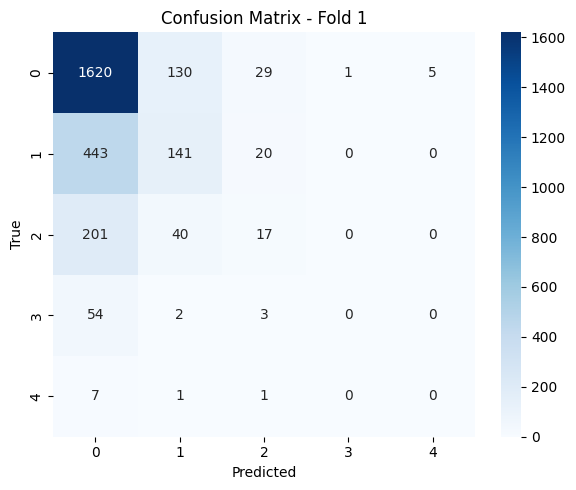

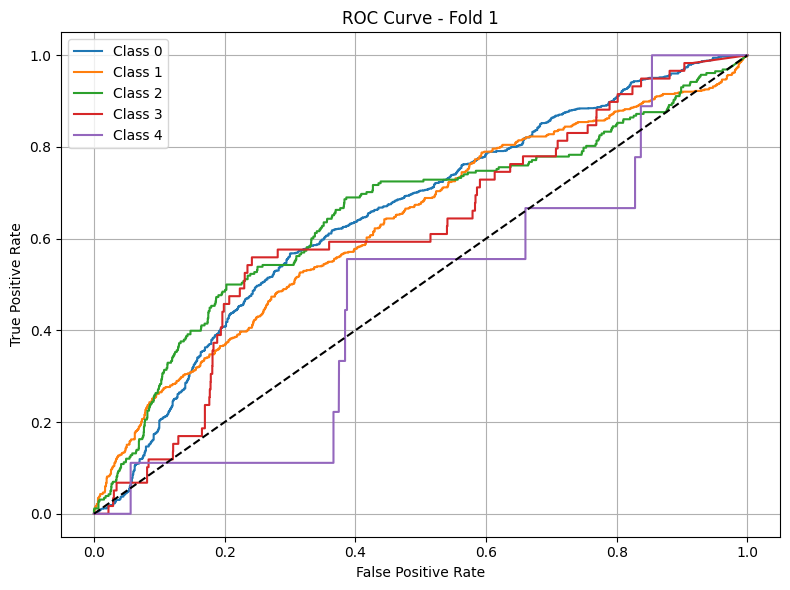


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1786
           1       0.44      0.22      0.30       603
           2       0.29      0.09      0.13       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2714
   macro avg       0.29      0.24      0.24      2714
weighted avg       0.59      0.66      0.60      2714



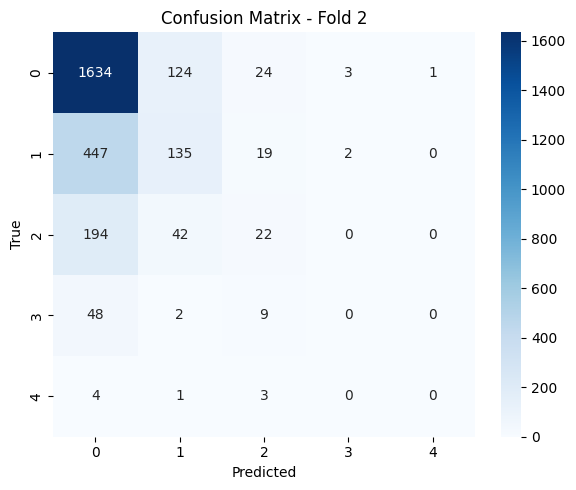

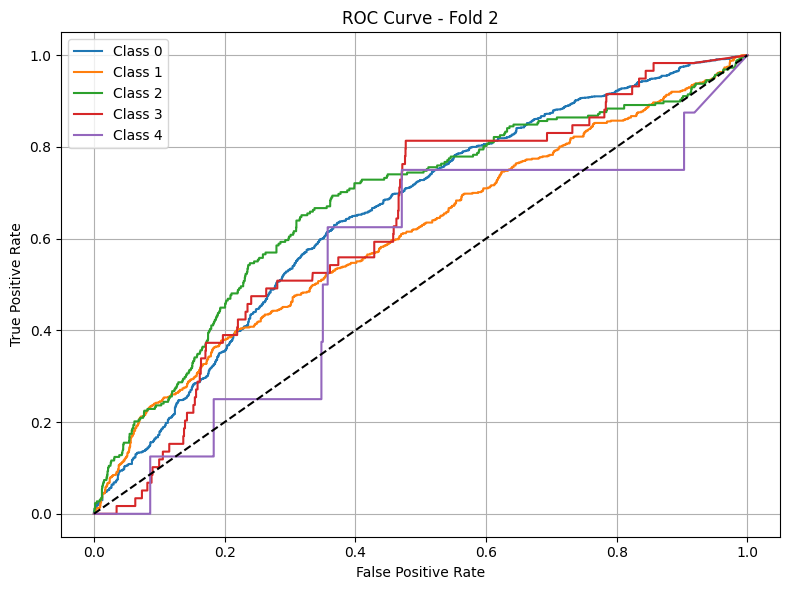


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.79      1786
           1       0.40      0.17      0.23       603
           2       0.26      0.12      0.16       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.65      2714
   macro avg       0.27      0.24      0.24      2714
weighted avg       0.57      0.65      0.59      2714



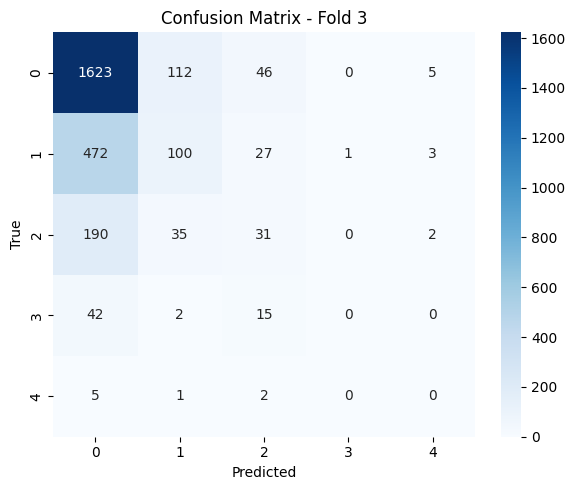

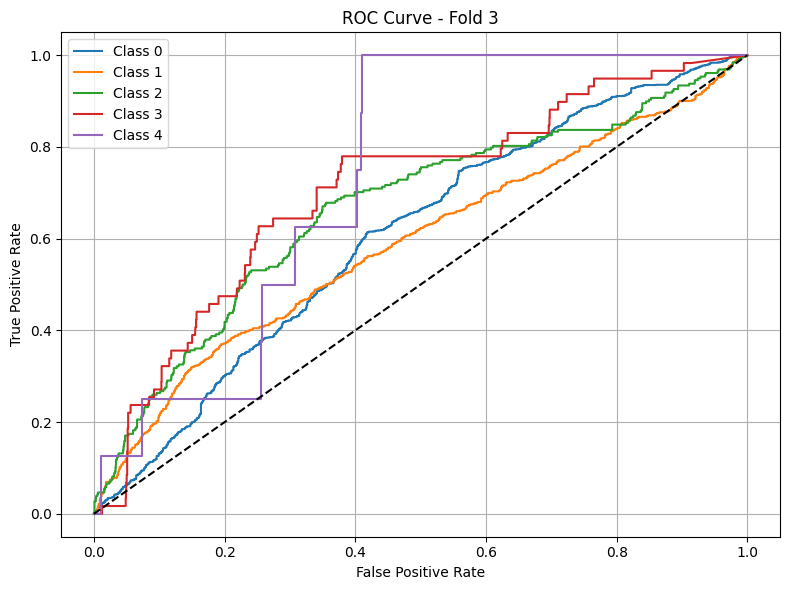

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.95      0.79      1785
           1       0.47      0.11      0.17       603
           2       0.16      0.03      0.06       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2714
   macro avg       0.26      0.22      0.20      2714
weighted avg       0.56      0.65      0.56      2714



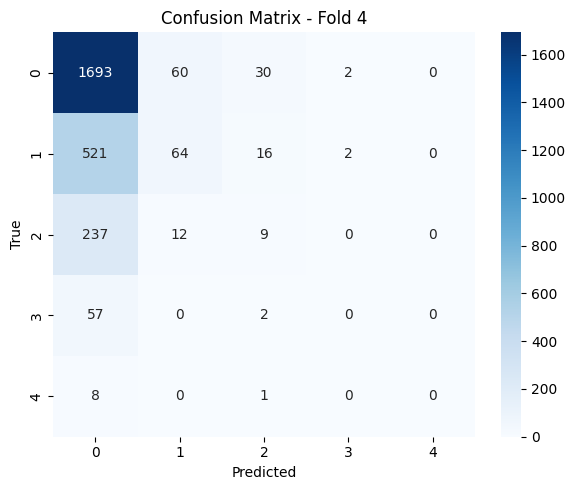

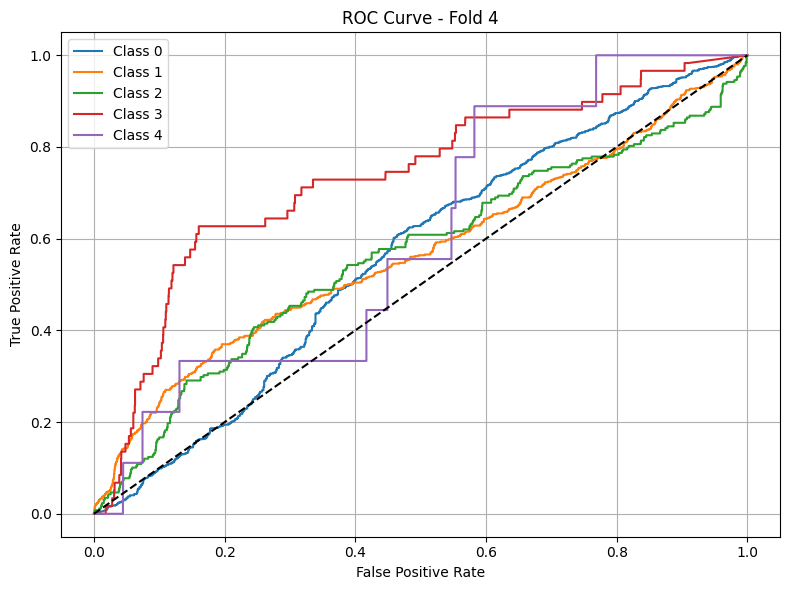

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.93      0.80      1785
           1       0.56      0.14      0.23       603
           2       0.25      0.19      0.22       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.66      2714
   macro avg       0.30      0.25      0.25      2714
weighted avg       0.61      0.66      0.60      2714



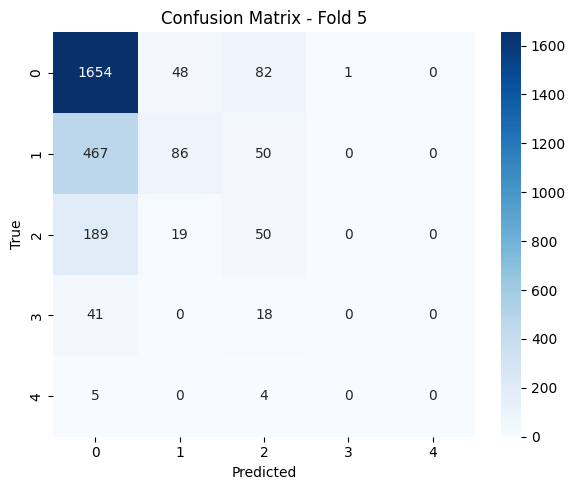

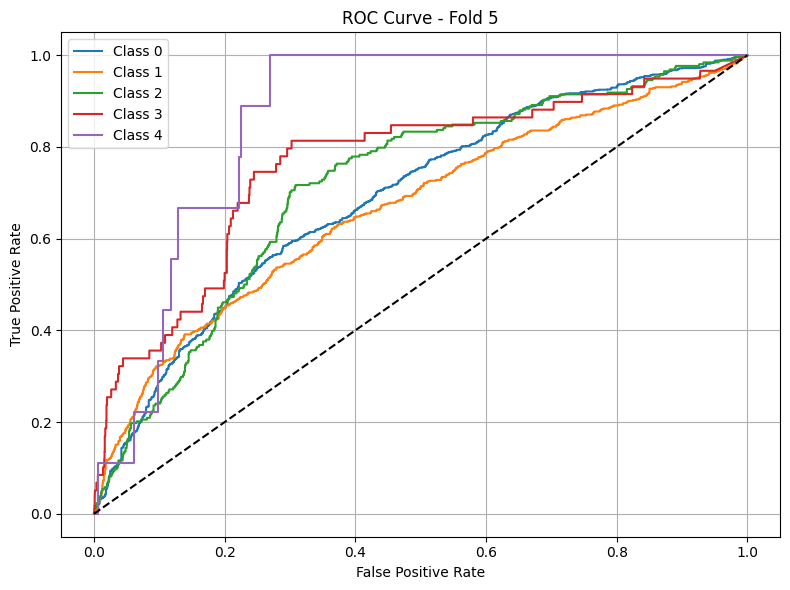


Average Accuracy: 0.6543
Average F1 Macro: 0.2348
Average AUC: 0.6466
{'phase1': [{'fold': 1, 'accuracy': 0.6548802946593002, 'f1_macro': 0.23983384939044758, 'auc': 0.604337990133134}, {'fold': 2, 'accuracy': 0.6599115696389094, 'f1_macro': 0.24471636239376707, 'auc': 0.6228932314115669}, {'fold': 3, 'accuracy': 0.6462785556374355, 'f1_macro': 0.23726034014440484, 'auc': 0.660026469634258}, {'fold': 4, 'accuracy': 0.6507000736919676, 'f1_macro': 0.2034855677761826, 'auc': 0.6067139304363168}, {'fold': 5, 'accuracy': 0.6595431098010317, 'f1_macro': 0.24856086073183392, 'auc': 0.7392150081220998}]}


======= Training Phase 2 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.92      0.79      1489
           1       0.34      0.13      0.19       488
           2       0.29      0.10      0.15       220
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         9


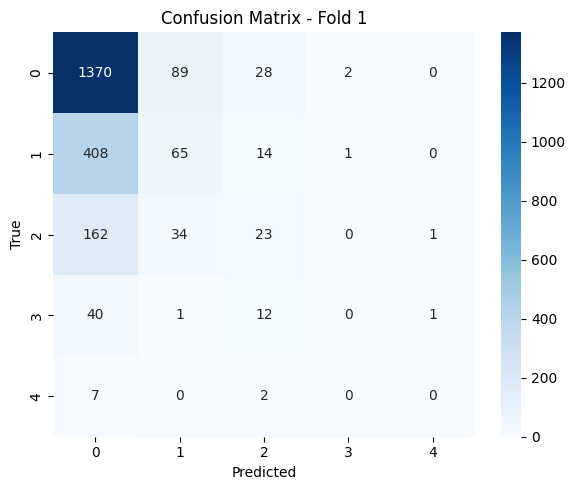

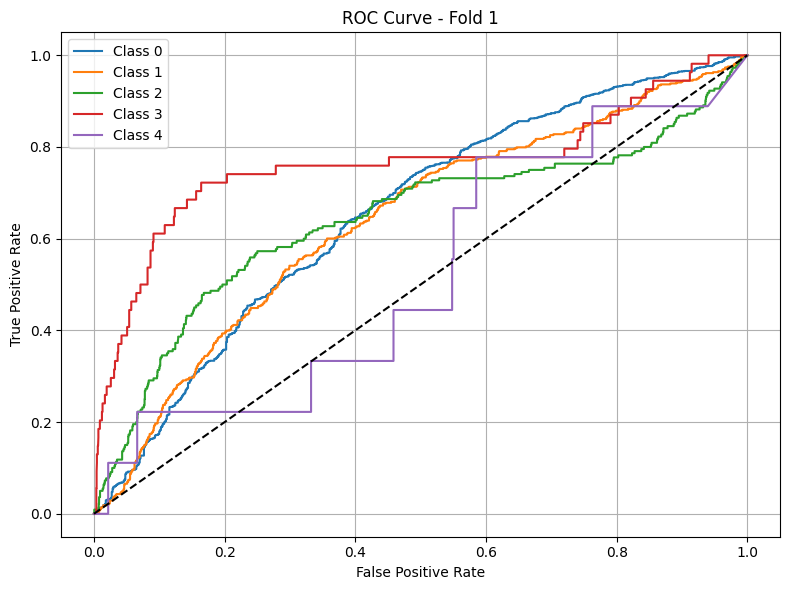


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79      1489
           1       0.41      0.19      0.26       489
           2       0.38      0.10      0.15       219
           3       0.19      0.09      0.12        55
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2260
   macro avg       0.34      0.26      0.27      2260
weighted avg       0.59      0.66      0.60      2260



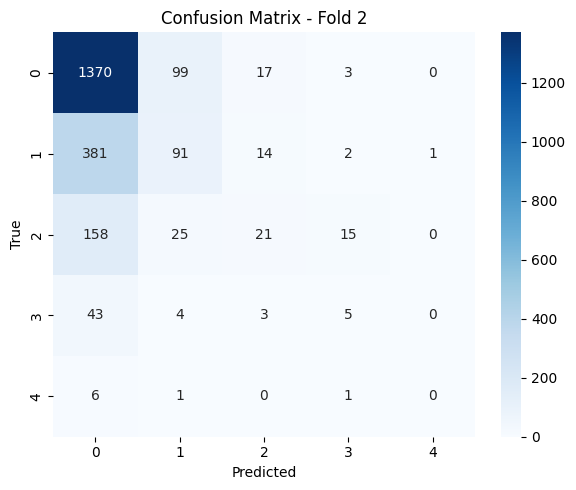

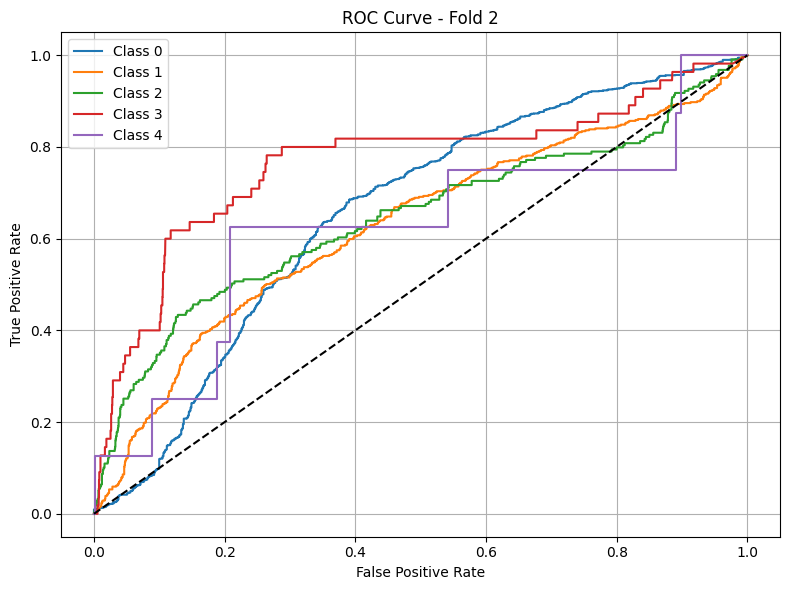


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.92      0.79      1489
           1       0.44      0.12      0.18       489
           2       0.27      0.19      0.23       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.65      2259
   macro avg       0.28      0.25      0.24      2259
weighted avg       0.58      0.65      0.58      2259



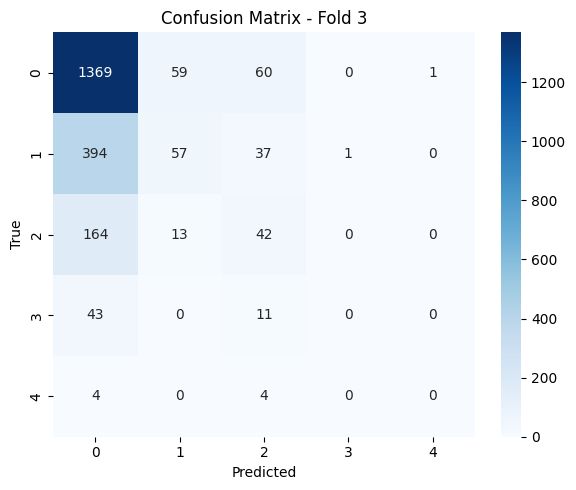

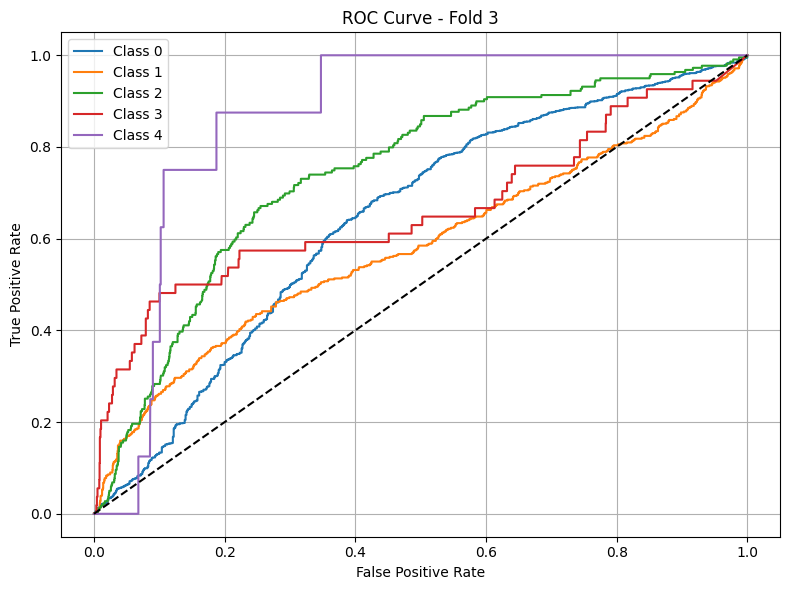


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.78      1489
           1       0.42      0.11      0.17       489
           2       0.26      0.09      0.14       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.64      2259
   macro avg       0.27      0.23      0.22      2259
weighted avg       0.56      0.64      0.57      2259



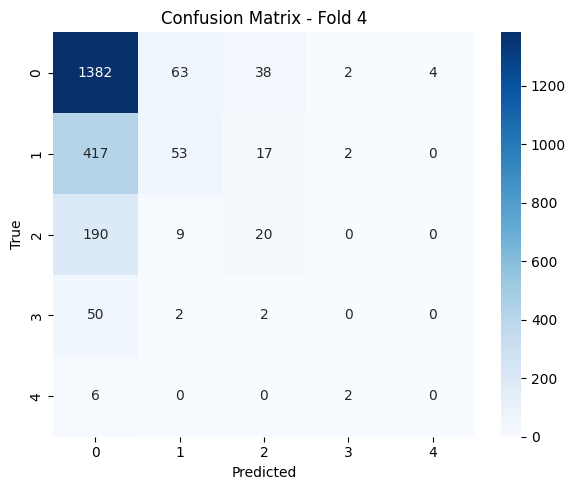

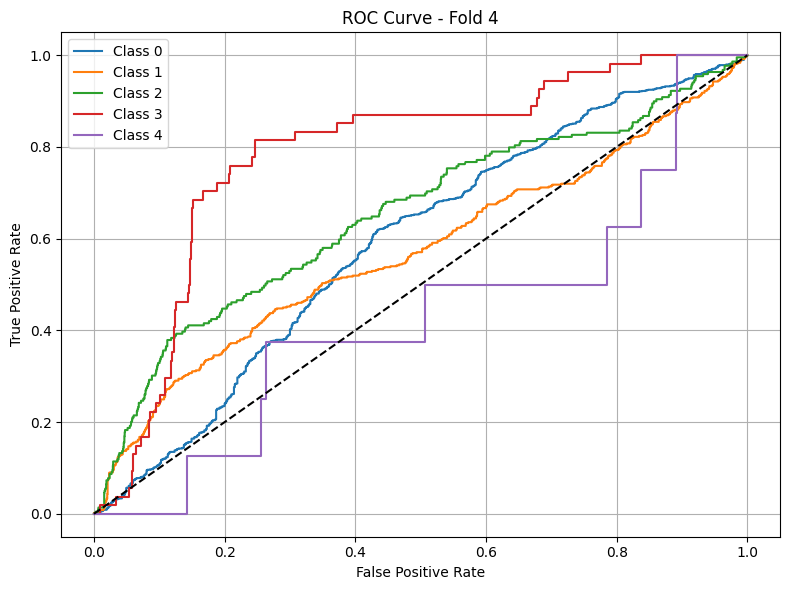


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.93      0.80      1490
           1       0.41      0.18      0.25       488
           2       0.31      0.02      0.04       219
           3       0.17      0.09      0.12        54
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2259
   macro avg       0.32      0.25      0.24      2259
weighted avg       0.58      0.66      0.59      2259



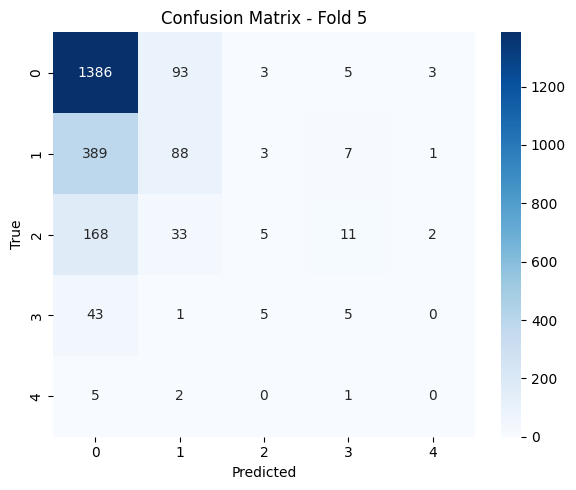

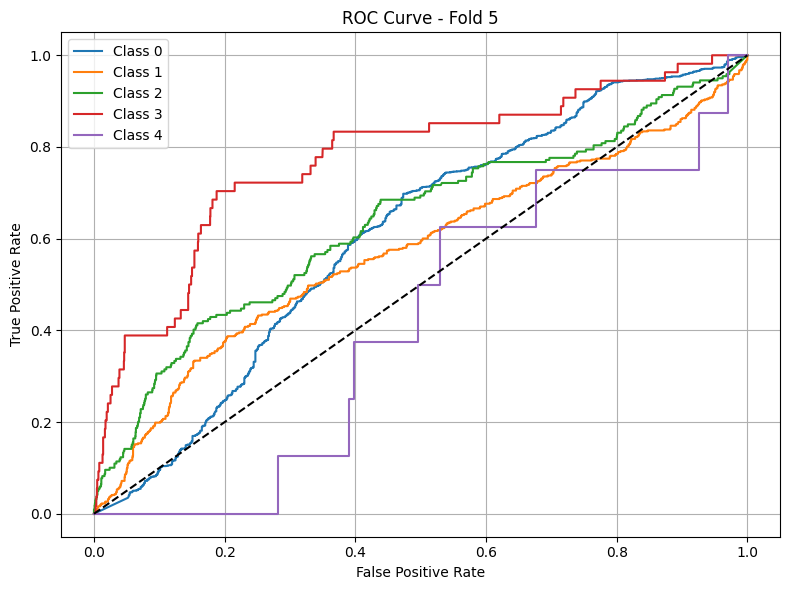


Average Accuracy: 0.6508
Average F1 Macro: 0.2384
Average AUC: 0.6426
{'phase1': [{'fold': 1, 'accuracy': 0.6548802946593002, 'f1_macro': 0.23983384939044758, 'auc': 0.604337990133134}, {'fold': 2, 'accuracy': 0.6599115696389094, 'f1_macro': 0.24471636239376707, 'auc': 0.6228932314115669}, {'fold': 3, 'accuracy': 0.6462785556374355, 'f1_macro': 0.23726034014440484, 'auc': 0.660026469634258}, {'fold': 4, 'accuracy': 0.6507000736919676, 'f1_macro': 0.2034855677761826, 'auc': 0.6067139304363168}, {'fold': 5, 'accuracy': 0.6595431098010317, 'f1_macro': 0.24856086073183392, 'auc': 0.7392150081220998}], 'phase2': [{'fold': 1, 'accuracy': 0.6451327433628319, 'f1_macro': 0.2268264316129993, 'auc': 0.6446017834732496}, {'fold': 2, 'accuracy': 0.6579646017699115, 'f1_macro': 0.2656670298692273, 'auc': 0.6631556192735533}, {'fold': 3, 'accuracy': 0.6498450641876937, 'f1_macro': 0.24006220842712334, 'auc': 0.6982270779992898}, {'fold': 4, 'accuracy': 0.6440903054448871, 'f1_macro': 0.217865927798

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.86      0.76      1361
           1       0.29      0.18      0.22       459
           2       0.30      0.12      0.17       198
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00         7

    accuracy                           0.62      2074
   macro avg       0.26      0.23      0.23      2074
weighted avg       0.54      0.62      0.57      2074



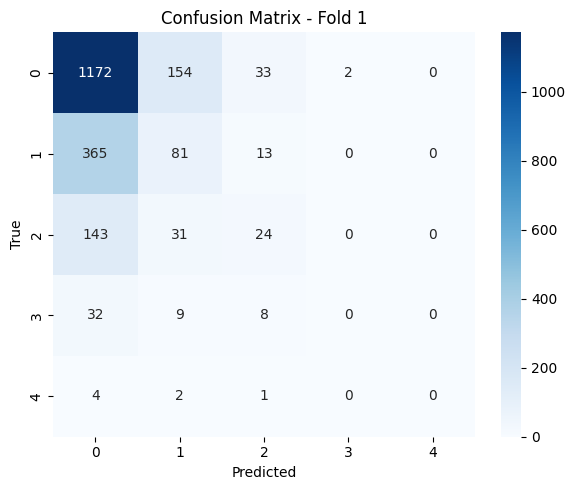

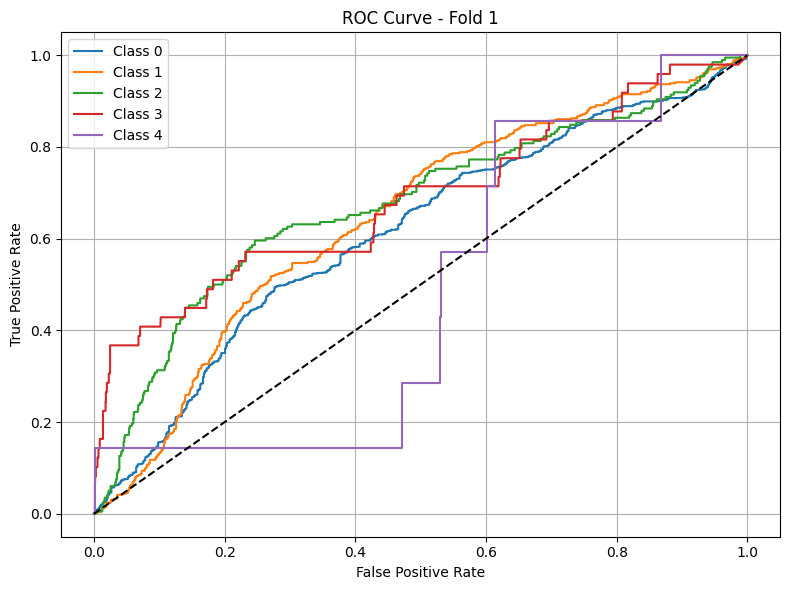

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.92      0.78      1360
           1       0.37      0.13      0.19       459
           2       0.24      0.10      0.14       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.64      2074
   macro avg       0.26      0.23      0.22      2074
weighted avg       0.55      0.64      0.57      2074



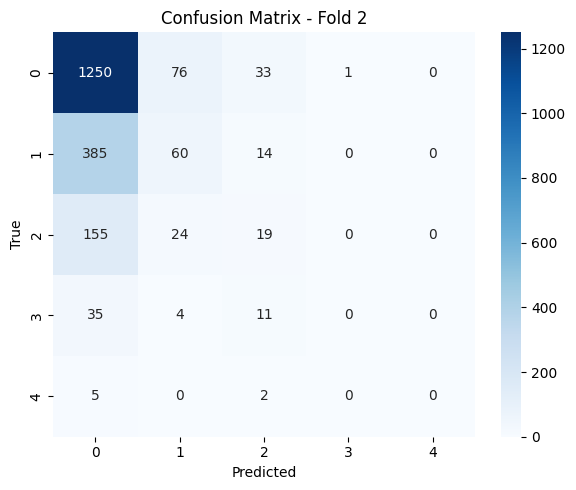

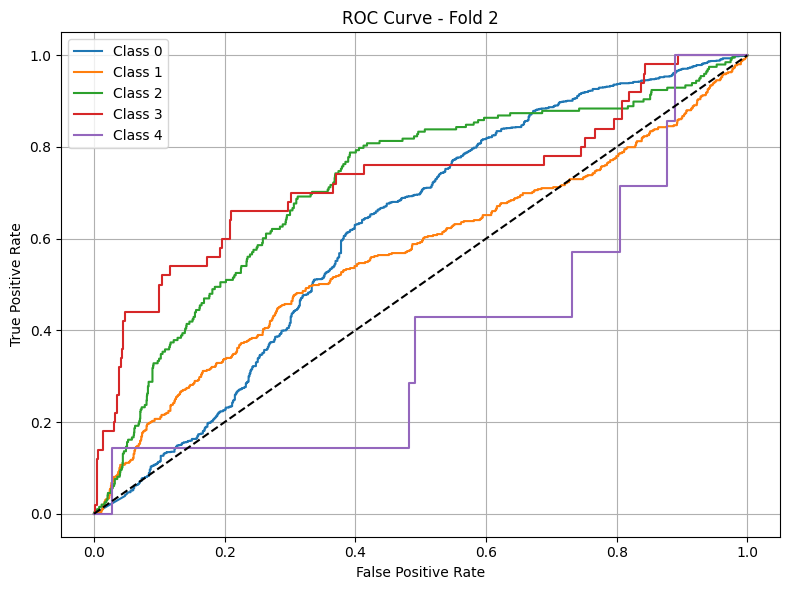


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.94      0.80      1360
           1       0.45      0.15      0.23       459
           2       0.26      0.10      0.14       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.66      2074
   macro avg       0.28      0.24      0.23      2074
weighted avg       0.58      0.66      0.59      2074



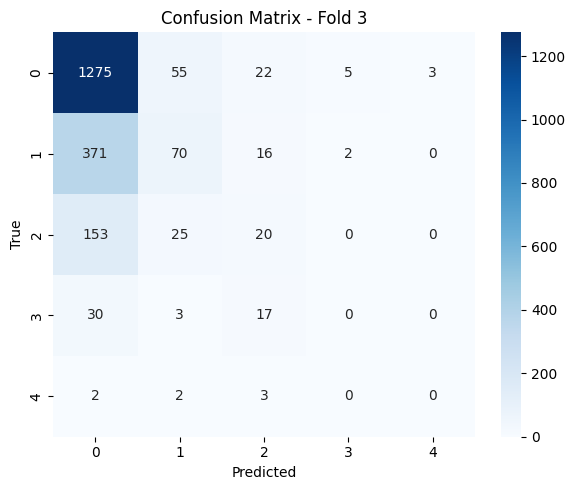

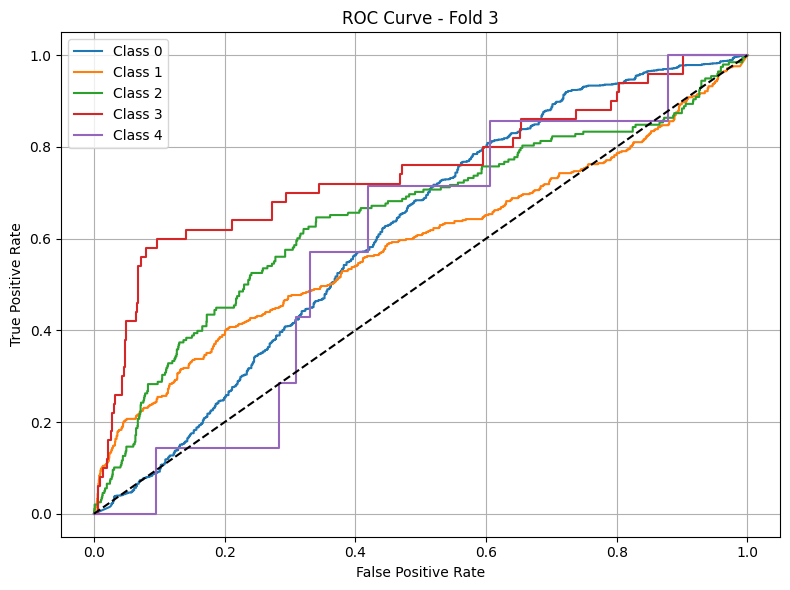


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.90      0.78      1360
           1       0.37      0.16      0.22       459
           2       0.15      0.06      0.09       198
           3       0.17      0.02      0.04        50
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.27      0.23      0.22      2074
weighted avg       0.55      0.63      0.57      2074



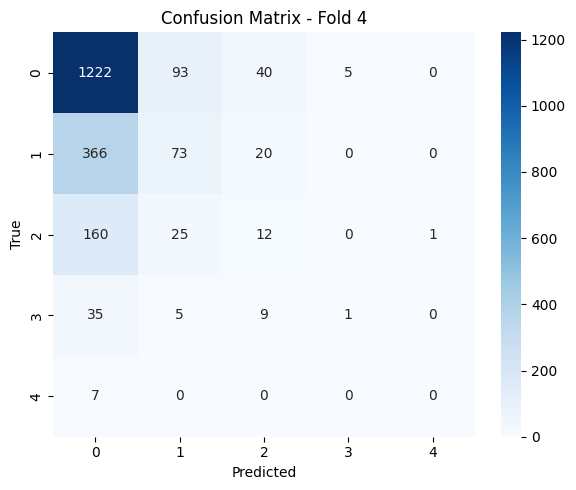

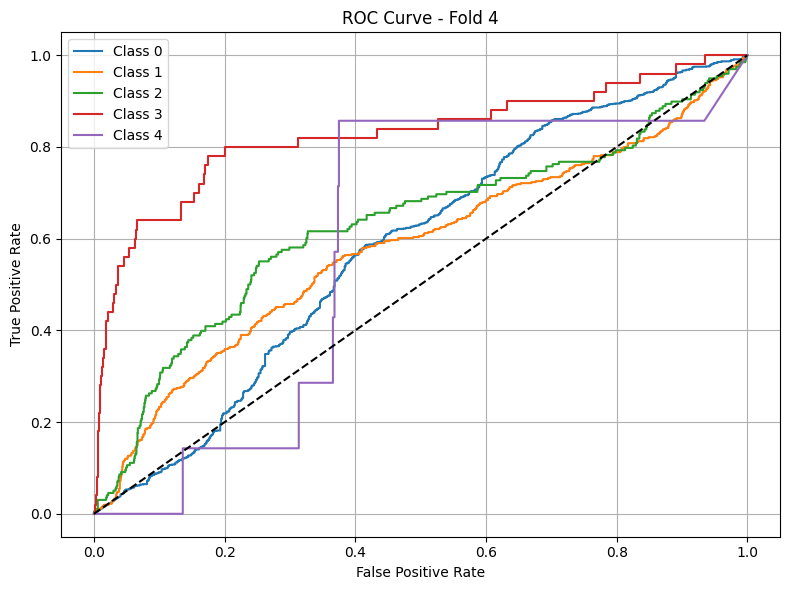

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80      1360
           1       0.42      0.21      0.28       460
           2       0.33      0.14      0.20       197
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00         7

    accuracy                           0.66      2073
   macro avg       0.29      0.25      0.26      2073
weighted avg       0.59      0.66      0.61      2073



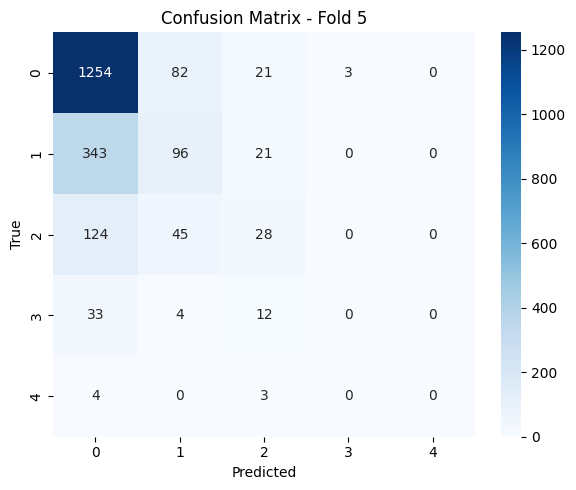

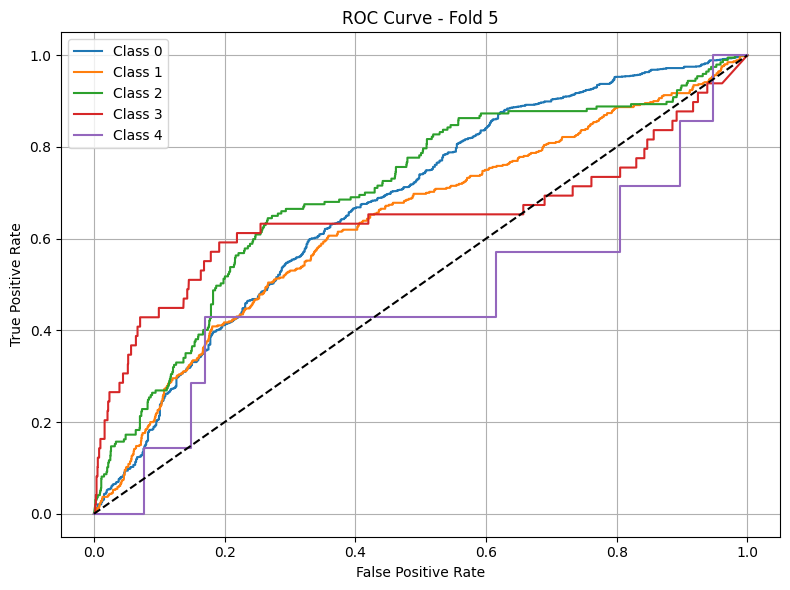


Average Accuracy: 0.6420
Average F1 Macro: 0.2337
Average AUC: 0.6253
{'phase1': [{'fold': 1, 'accuracy': 0.6548802946593002, 'f1_macro': 0.23983384939044758, 'auc': 0.604337990133134}, {'fold': 2, 'accuracy': 0.6599115696389094, 'f1_macro': 0.24471636239376707, 'auc': 0.6228932314115669}, {'fold': 3, 'accuracy': 0.6462785556374355, 'f1_macro': 0.23726034014440484, 'auc': 0.660026469634258}, {'fold': 4, 'accuracy': 0.6507000736919676, 'f1_macro': 0.2034855677761826, 'auc': 0.6067139304363168}, {'fold': 5, 'accuracy': 0.6595431098010317, 'f1_macro': 0.24856086073183392, 'auc': 0.7392150081220998}], 'phase2': [{'fold': 1, 'accuracy': 0.6451327433628319, 'f1_macro': 0.2268264316129993, 'auc': 0.6446017834732496}, {'fold': 2, 'accuracy': 0.6579646017699115, 'f1_macro': 0.2656670298692273, 'auc': 0.6631556192735533}, {'fold': 3, 'accuracy': 0.6498450641876937, 'f1_macro': 0.24006220842712334, 'auc': 0.6982270779992898}, {'fold': 4, 'accuracy': 0.6440903054448871, 'f1_macro': 0.217865927798

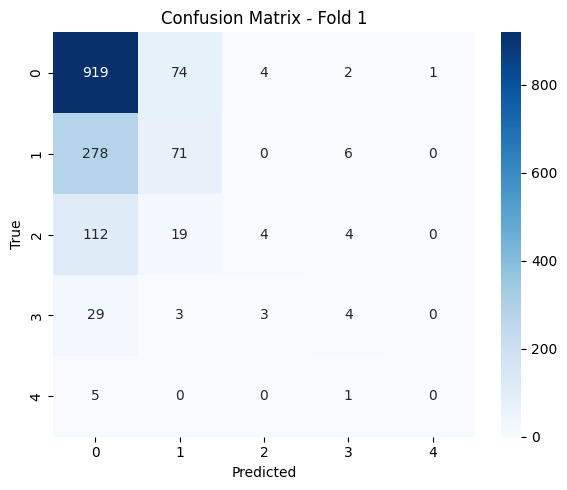

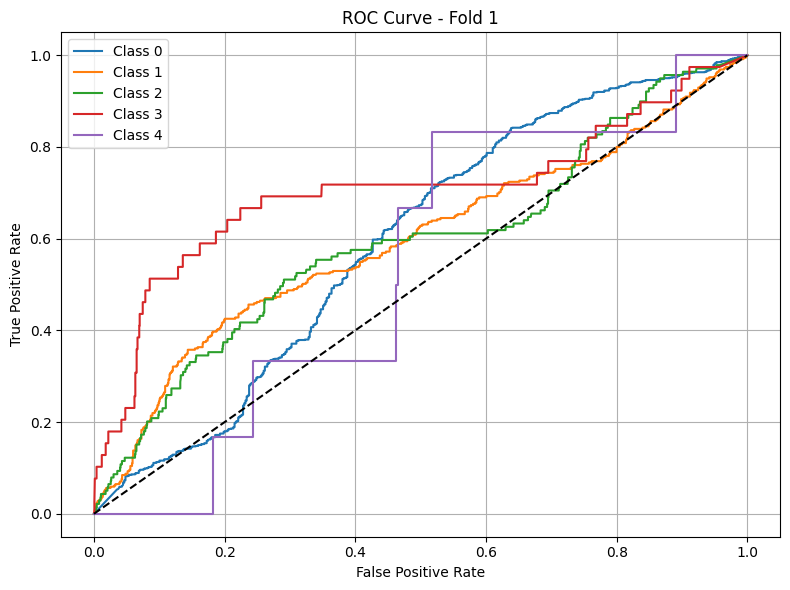


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.93      0.79      1000
           1       0.43      0.19      0.26       355
           2       0.41      0.14      0.21       139
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         5

    accuracy                           0.66      1539
   macro avg       0.31      0.25      0.25      1539
weighted avg       0.59      0.66      0.60      1539



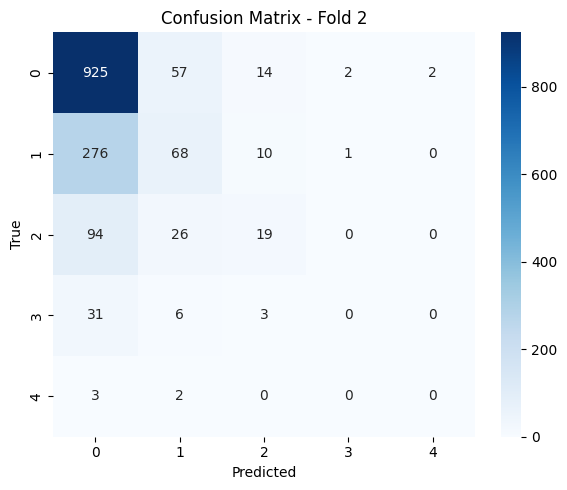

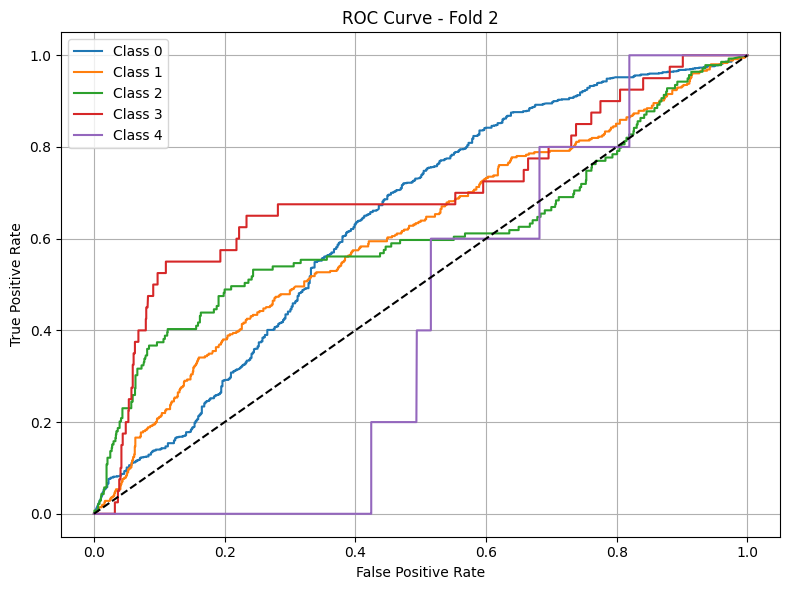

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.91      0.78       999
           1       0.42      0.14      0.21       355
           2       0.25      0.14      0.18       139
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         6

    accuracy                           0.64      1539
   macro avg       0.27      0.24      0.23      1539
weighted avg       0.56      0.64      0.57      1539



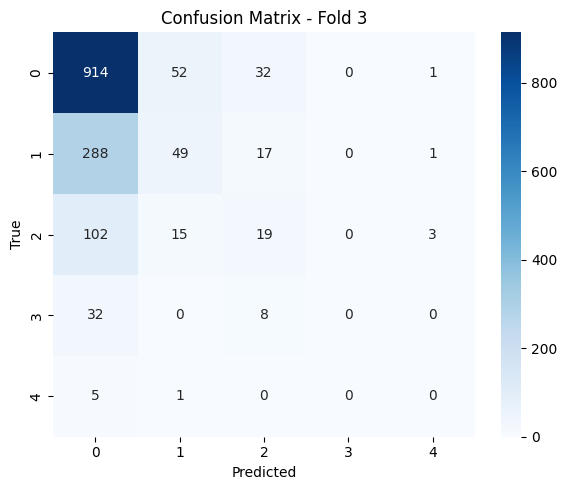

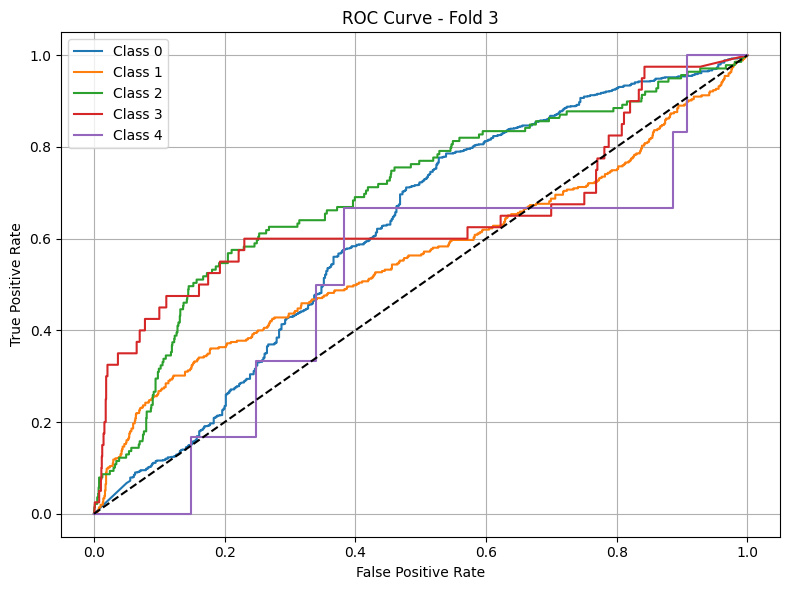


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.90      0.78       999
           1       0.40      0.20      0.27       356
           2       0.41      0.12      0.18       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.64      1538
   macro avg       0.30      0.24      0.25      1538
weighted avg       0.58      0.64      0.59      1538



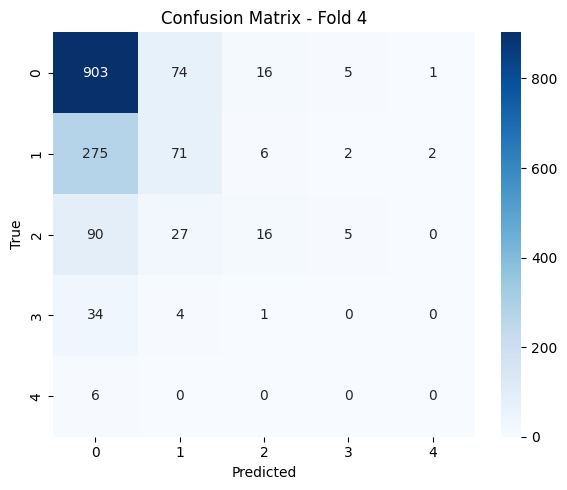

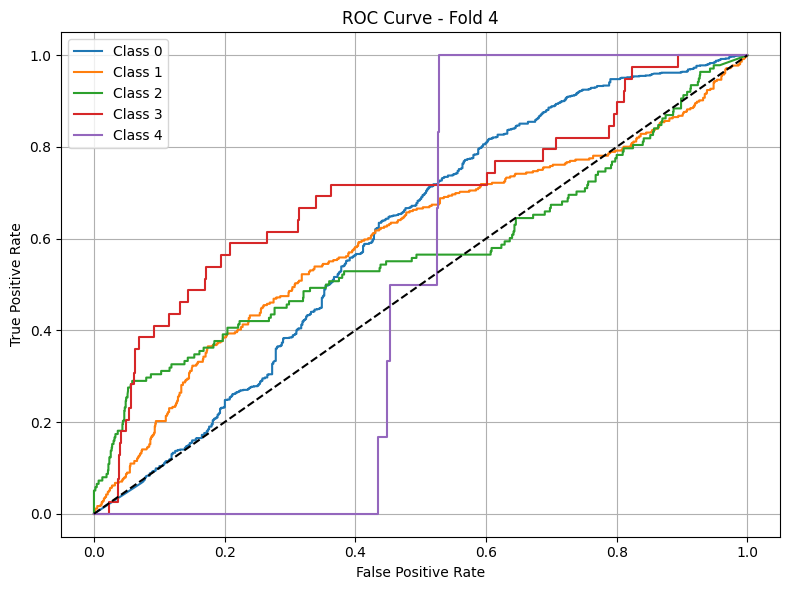

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.77       999
           1       0.36      0.23      0.28       356
           2       0.25      0.04      0.07       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.63      1538
   macro avg       0.26      0.23      0.22      1538
weighted avg       0.55      0.63      0.57      1538



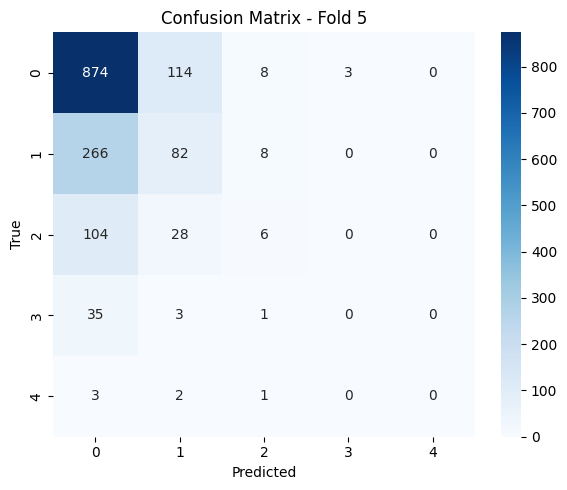

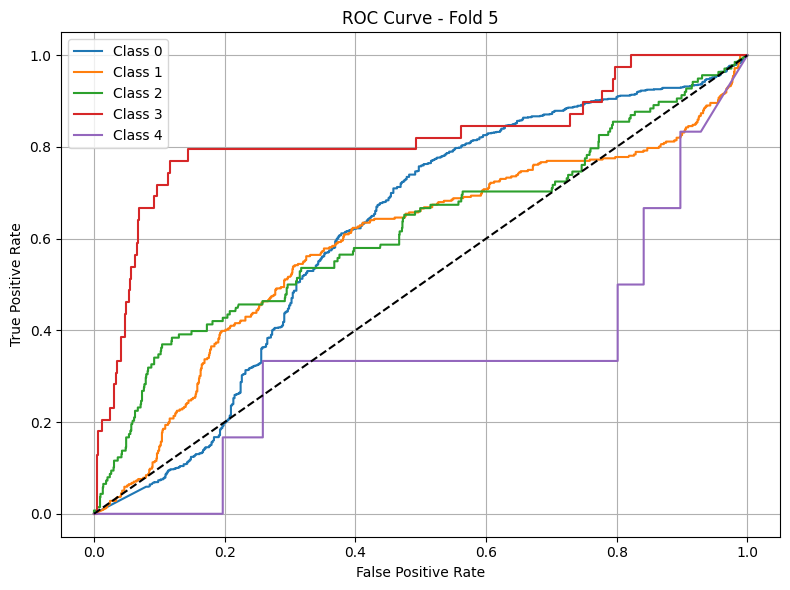


Average Accuracy: 0.6427
Average F1 Macro: 0.2414
Average AUC: 0.6000
{'phase1': [{'fold': 1, 'accuracy': 0.6548802946593002, 'f1_macro': 0.23983384939044758, 'auc': 0.604337990133134}, {'fold': 2, 'accuracy': 0.6599115696389094, 'f1_macro': 0.24471636239376707, 'auc': 0.6228932314115669}, {'fold': 3, 'accuracy': 0.6462785556374355, 'f1_macro': 0.23726034014440484, 'auc': 0.660026469634258}, {'fold': 4, 'accuracy': 0.6507000736919676, 'f1_macro': 0.2034855677761826, 'auc': 0.6067139304363168}, {'fold': 5, 'accuracy': 0.6595431098010317, 'f1_macro': 0.24856086073183392, 'auc': 0.7392150081220998}], 'phase2': [{'fold': 1, 'accuracy': 0.6451327433628319, 'f1_macro': 0.2268264316129993, 'auc': 0.6446017834732496}, {'fold': 2, 'accuracy': 0.6579646017699115, 'f1_macro': 0.2656670298692273, 'auc': 0.6631556192735533}, {'fold': 3, 'accuracy': 0.6498450641876937, 'f1_macro': 0.24006220842712334, 'auc': 0.6982270779992898}, {'fold': 4, 'accuracy': 0.6440903054448871, 'f1_macro': 0.217865927798

In [7]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = False
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")

    results[f"phase{i}"] = metrics
    print(results)



Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       568
           1       0.23      0.10      0.13        63
           2       0.07      0.26      0.11        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.63       698
   macro avg       0.23      0.22      0.21       698
weighted avg       0.70      0.63      0.66       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


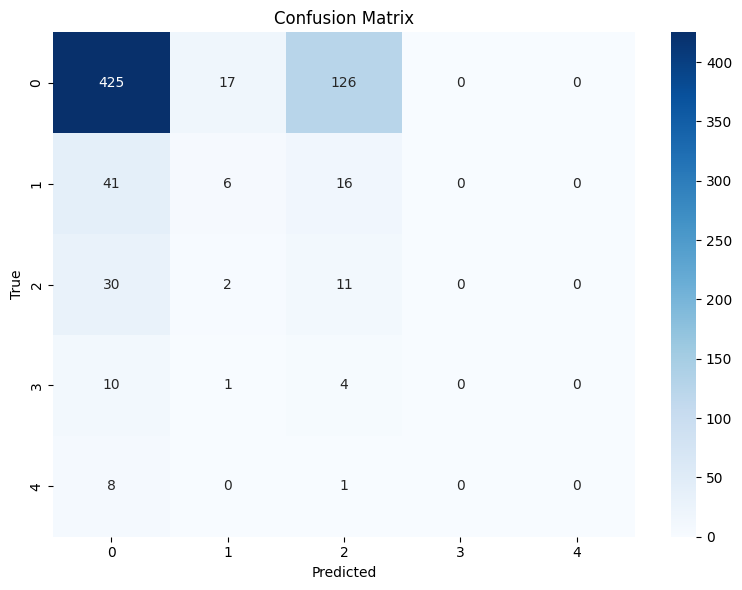


Test AUC (macro-average, OVR): 0.4710


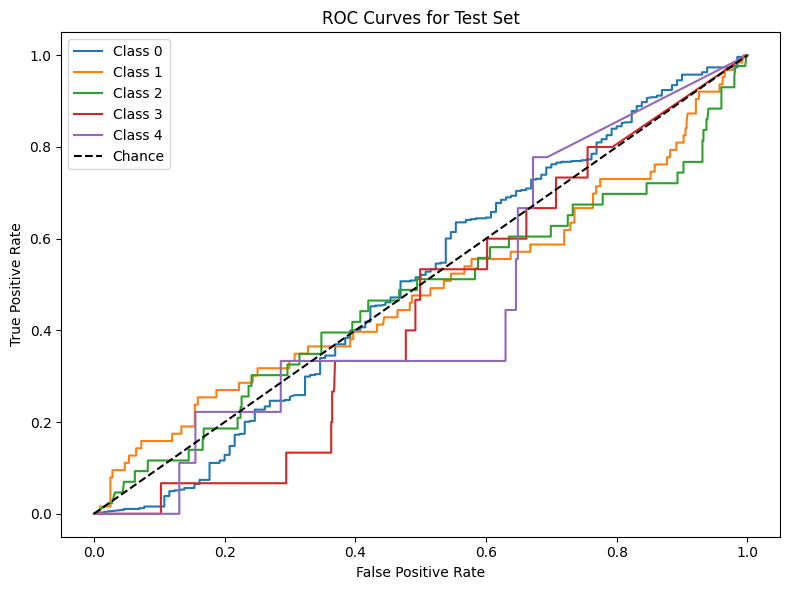


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       544
           1       0.29      0.59      0.39        59
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.24      0.30      0.26       668
weighted avg       0.77      0.80      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


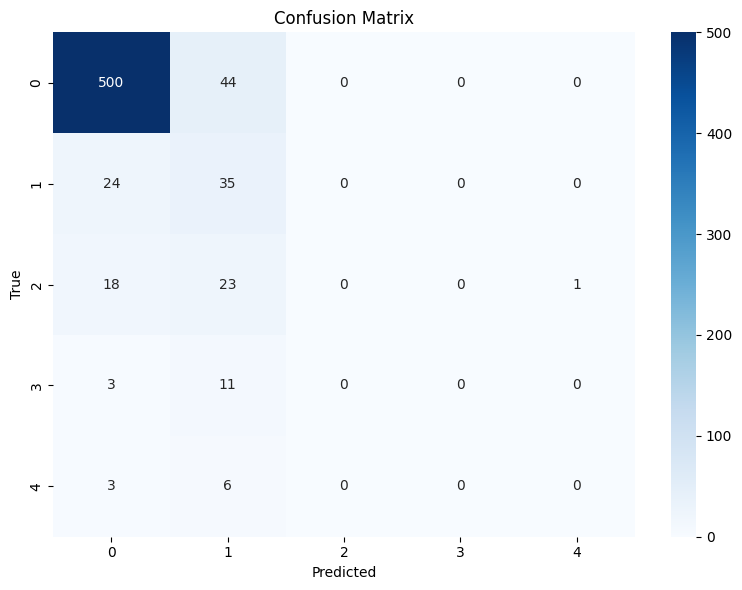


Test AUC (macro-average, OVR): 0.5409


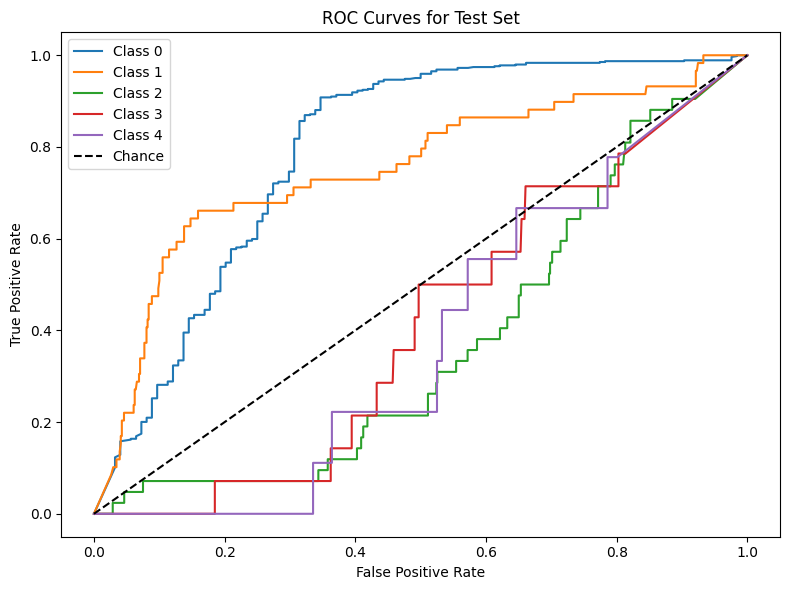


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.67      0.76       455
           1       0.10      0.25      0.14        52
           2       0.11      0.24      0.15        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.59       554
   macro avg       0.22      0.23      0.21       554
weighted avg       0.74      0.59      0.65       554



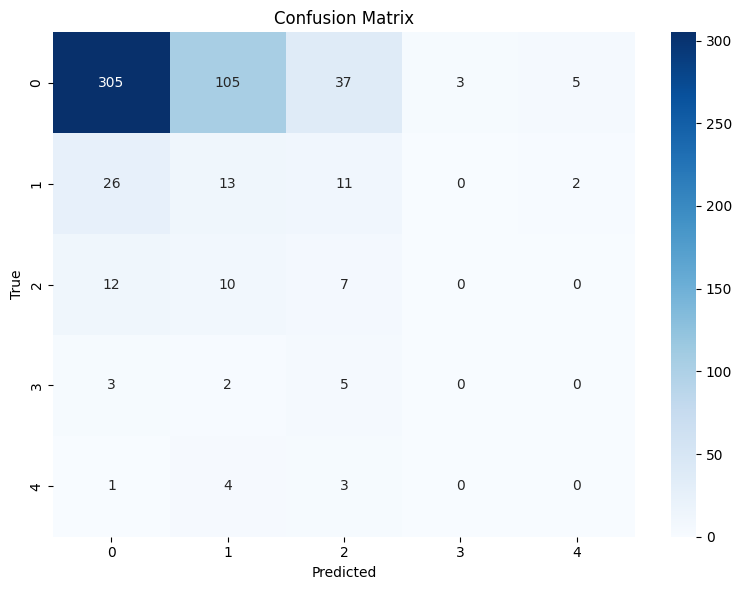


Test AUC (macro-average, OVR): 0.4745


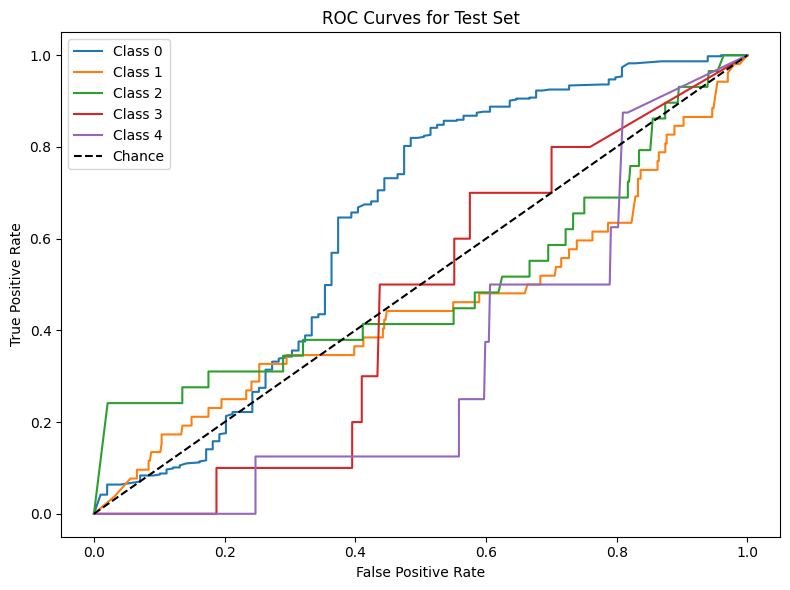


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       395
           1       0.24      0.23      0.23        40
           2       0.07      0.04      0.05        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.77       477
   macro avg       0.23      0.23      0.23       477
weighted avg       0.72      0.77      0.74       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


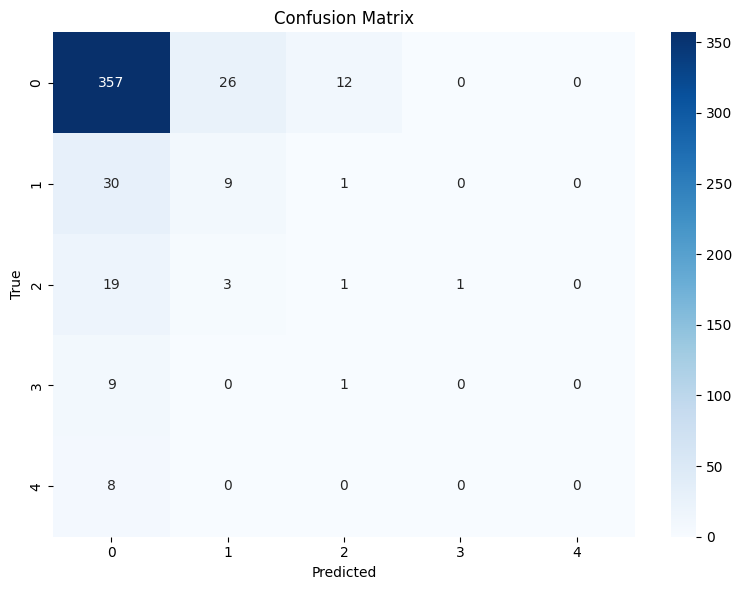


Test AUC (macro-average, OVR): 0.4501


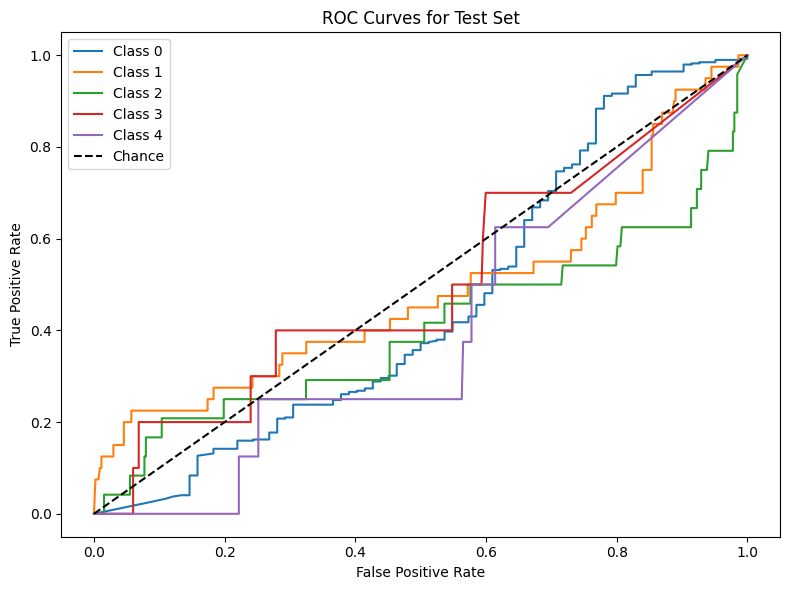

In [8]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )


# Sample Data



======= Training Phase 1 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.52      0.65      1785
           1       0.38      0.49      0.43       604
           2       0.20      0.45      0.28       258
           3       0.15      0.49      0.23        59
           4       0.06      0.44      0.10         9

    accuracy                           0.51      2715
   macro avg       0.33      0.48      0.34      2715
weighted avg       0.67      0.51      0.55      2715



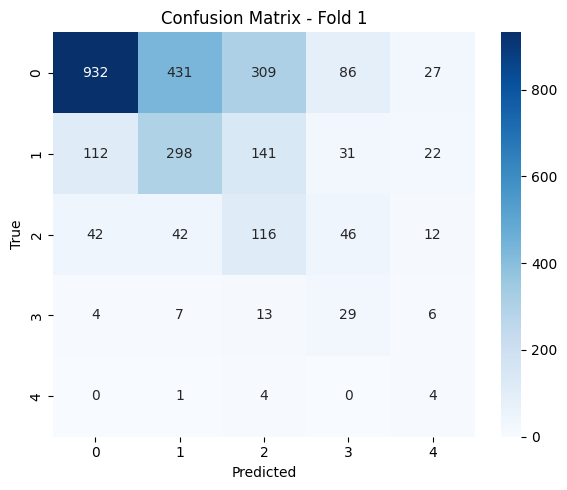

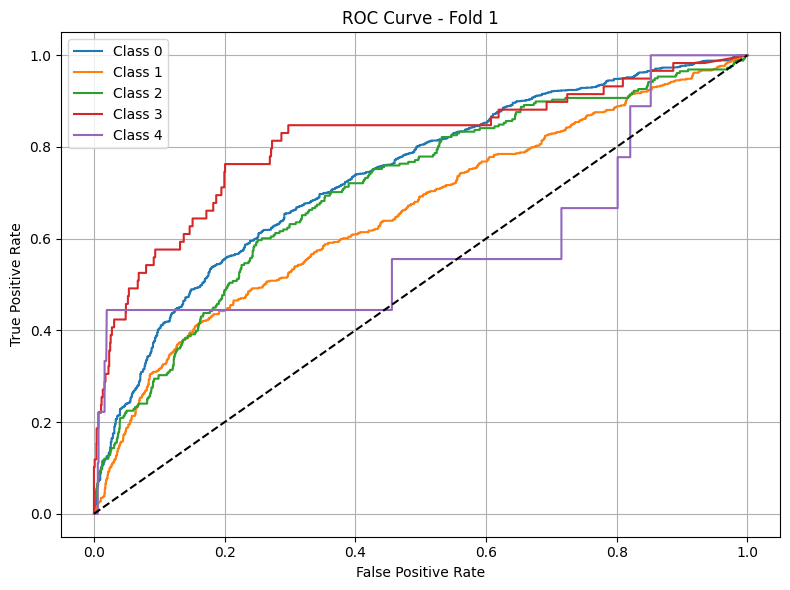


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.44      0.57      1786
           1       0.32      0.47      0.38       603
           2       0.21      0.45      0.29       258
           3       0.13      0.53      0.21        59
           4       0.06      0.50      0.10         8

    accuracy                           0.45      2714
   macro avg       0.30      0.48      0.31      2714
weighted avg       0.62      0.45      0.49      2714



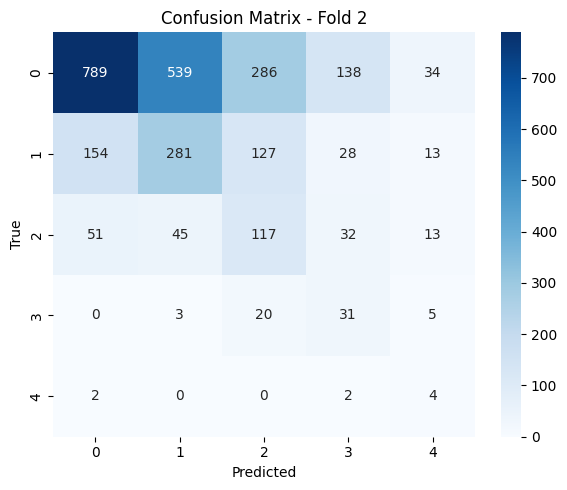

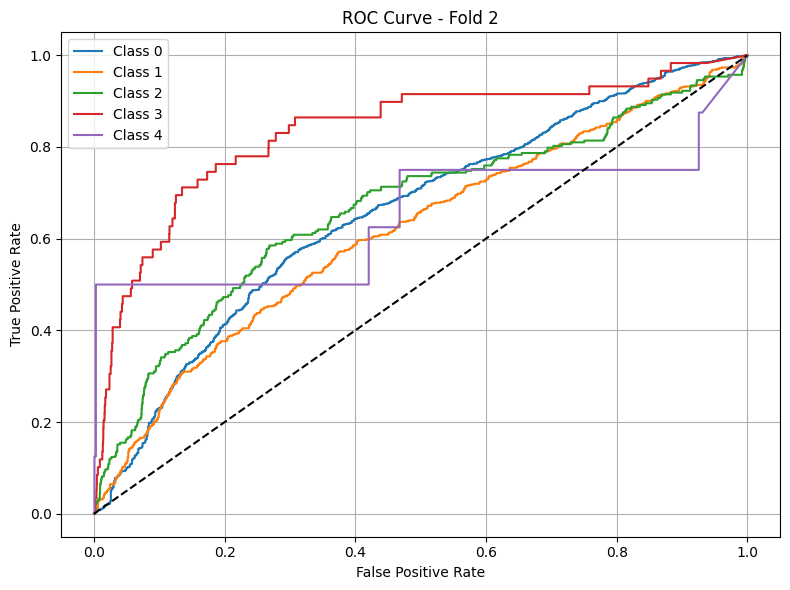


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.50      0.62      1786
           1       0.35      0.44      0.39       603
           2       0.20      0.40      0.27       258
           3       0.12      0.54      0.20        59
           4       0.07      0.62      0.12         8

    accuracy                           0.48      2714
   macro avg       0.31      0.50      0.32      2714
weighted avg       0.63      0.48      0.53      2714



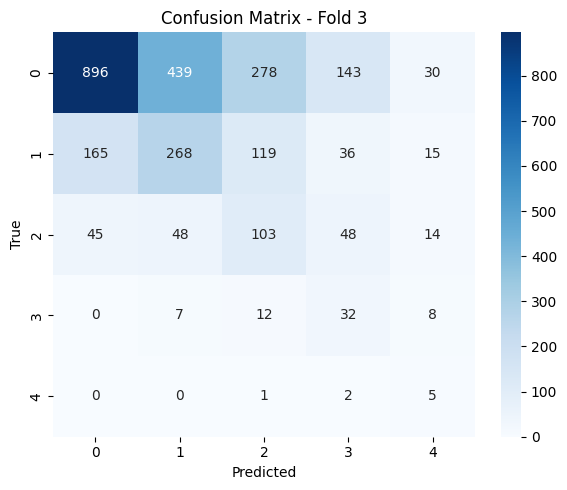

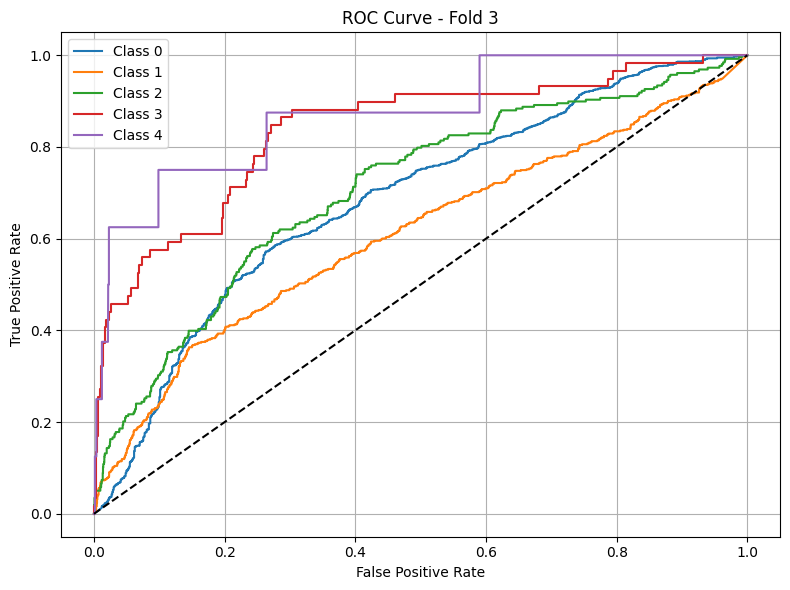


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.41      0.54      1785
           1       0.33      0.47      0.39       603
           2       0.18      0.43      0.25       258
           3       0.15      0.53      0.23        59
           4       0.06      0.56      0.10         9

    accuracy                           0.43      2714
   macro avg       0.30      0.48      0.30      2714
weighted avg       0.61      0.43      0.47      2714



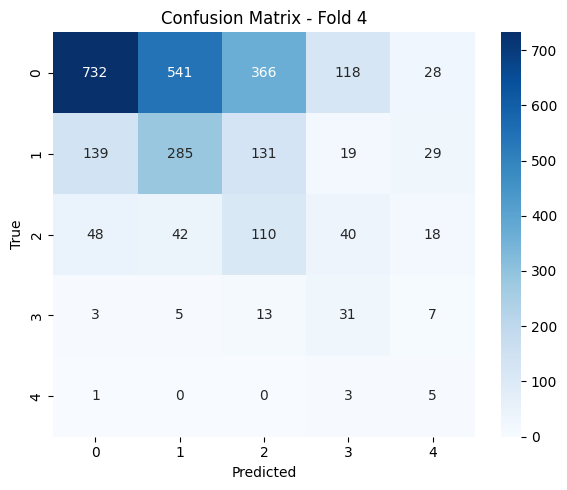

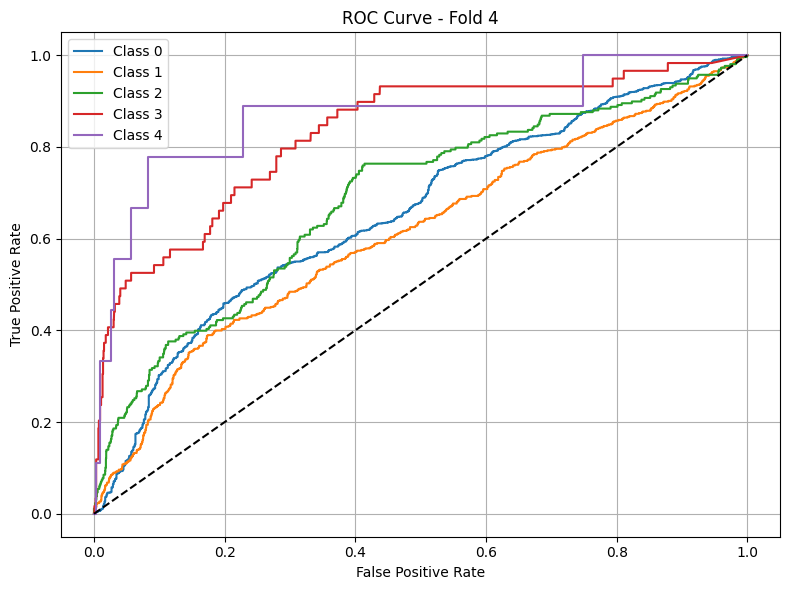


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.44      0.57      1785
           1       0.37      0.44      0.40       603
           2       0.17      0.44      0.24       258
           3       0.13      0.63      0.21        59
           4       0.06      0.44      0.10         9

    accuracy                           0.44      2714
   macro avg       0.31      0.48      0.31      2714
weighted avg       0.64      0.44      0.49      2714



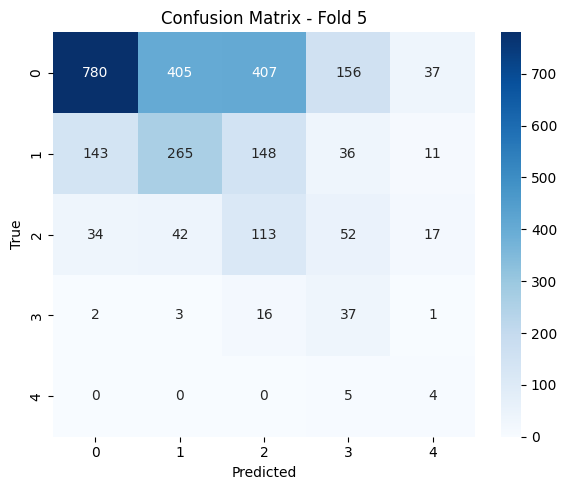

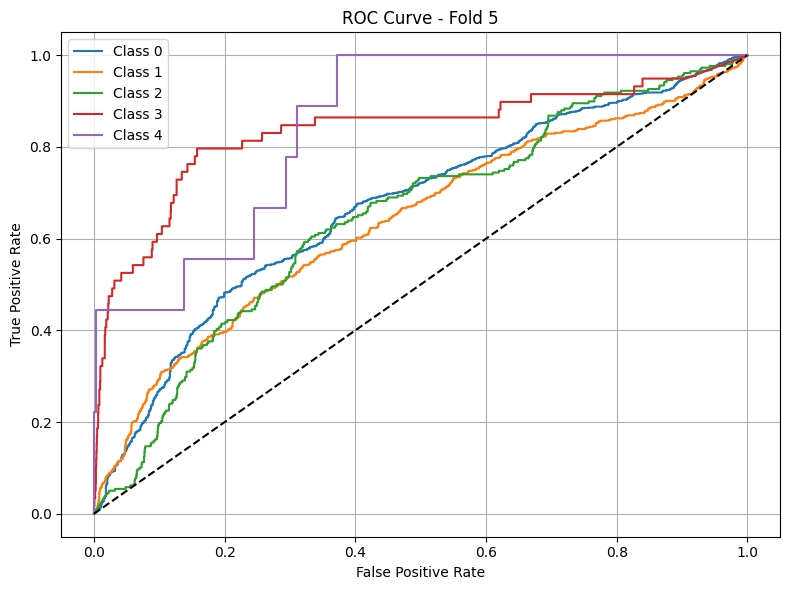


Average Accuracy: 0.4618
Average F1 Macro: 0.3154
Average AUC: 0.7170
{'phase1': [{'fold': 1, 'accuracy': 0.5079189686924493, 'f1_macro': 0.3372465616920607, 'auc': 0.7006312129640854}, {'fold': 2, 'accuracy': 0.45025792188651437, 'f1_macro': 0.3113128043586897, 'auc': 0.684101911590709}, {'fold': 3, 'accuracy': 0.48047162859248344, 'f1_macro': 0.32089997067207776, 'auc': 0.7425869861377731}, {'fold': 4, 'accuracy': 0.4285187914517318, 'f1_macro': 0.30223300364283723, 'auc': 0.7304120972753347}, {'fold': 5, 'accuracy': 0.44178334561532795, 'f1_macro': 0.3052622402414998, 'auc': 0.7274431692695017}]}


======= Training Phase 2 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.53      0.64      1489
           1       0.33      0.46      0.38       488
           2       0.25      0.51      0.33       220
           3       0.24      0.59      0.34        54
           4       0.04      0.11      0.06         

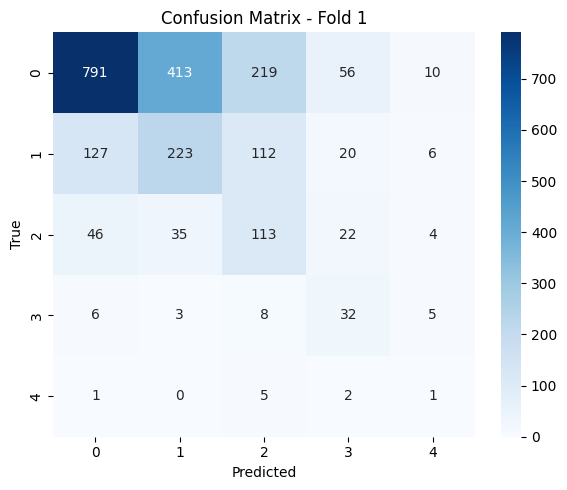

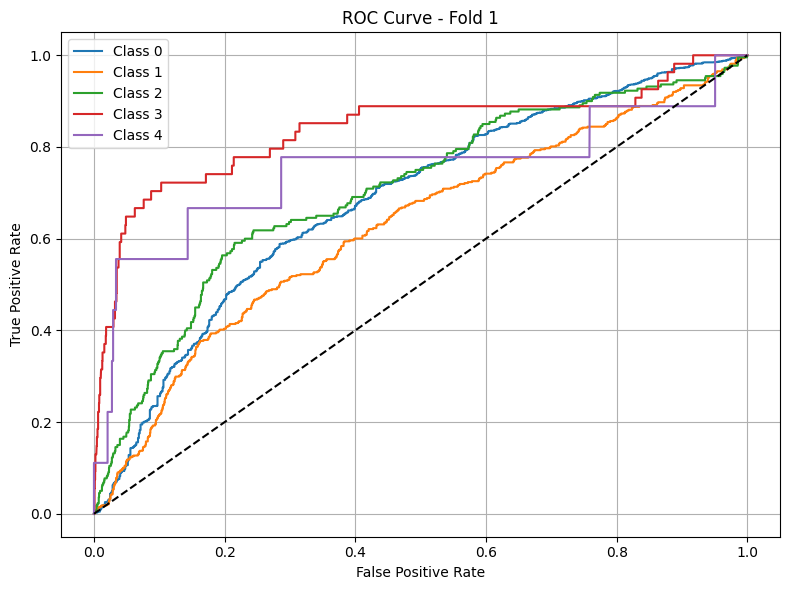


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.51      0.62      1489
           1       0.35      0.42      0.38       489
           2       0.20      0.47      0.28       219
           3       0.15      0.51      0.24        55
           4       0.11      0.50      0.18         8

    accuracy                           0.48      2260
   macro avg       0.32      0.48      0.34      2260
weighted avg       0.63      0.48      0.53      2260



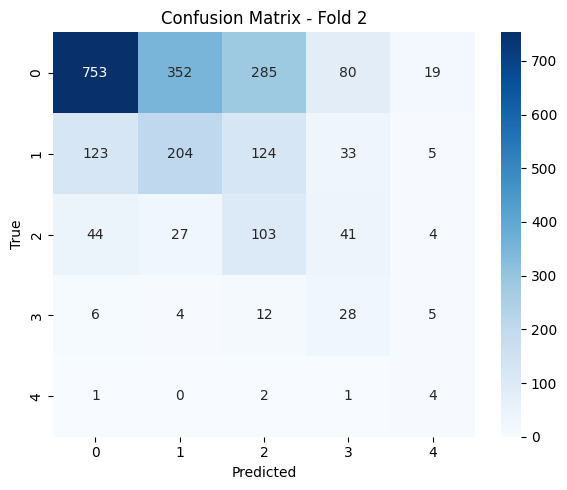

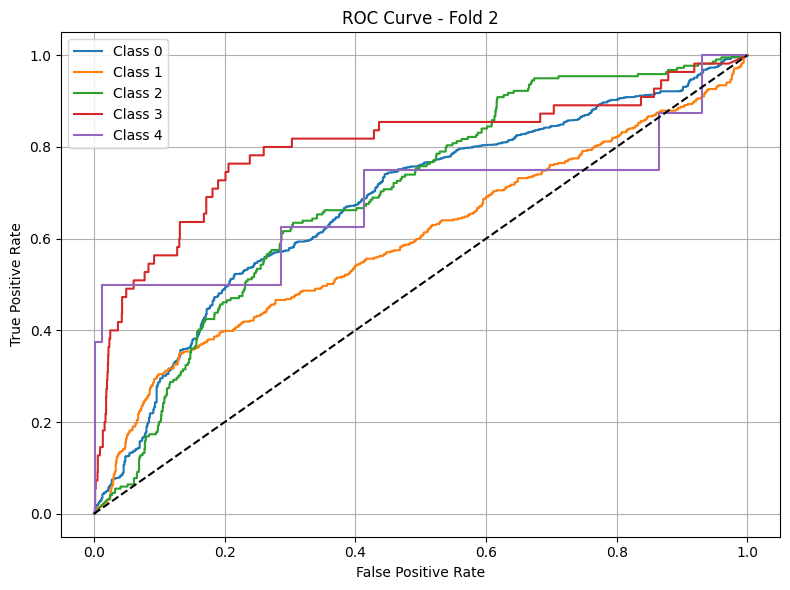


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.49      0.61      1489
           1       0.36      0.45      0.40       489
           2       0.22      0.50      0.31       219
           3       0.15      0.46      0.23        54
           4       0.07      0.62      0.13         8

    accuracy                           0.48      2259
   macro avg       0.32      0.51      0.33      2259
weighted avg       0.63      0.48      0.52      2259



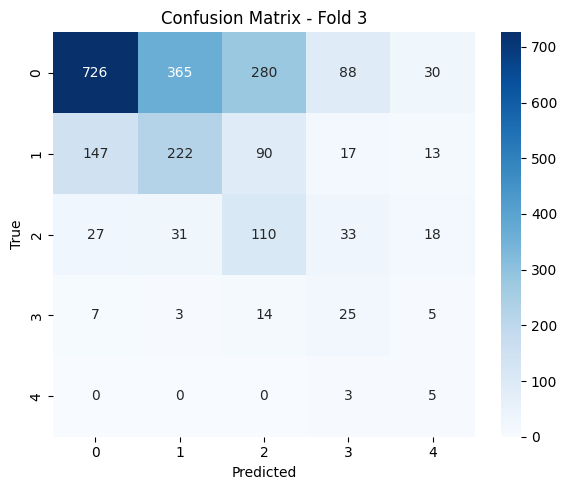

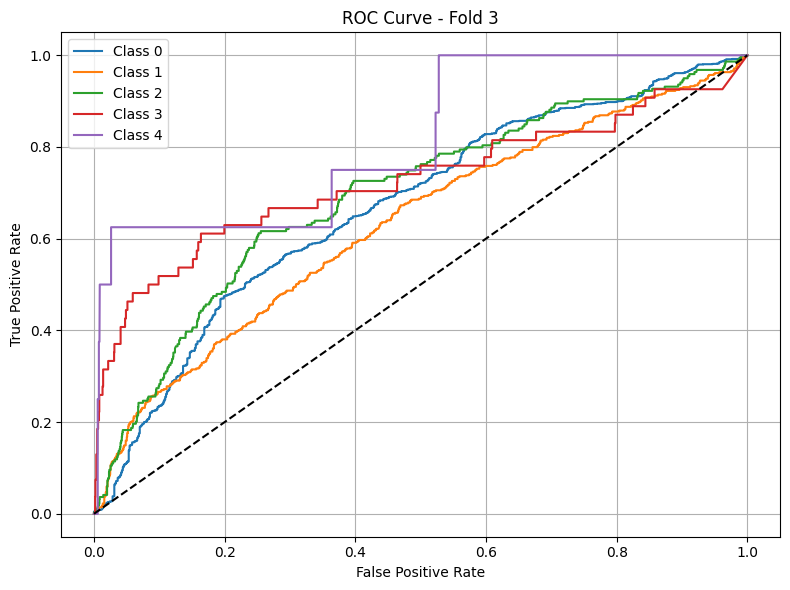


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.50      0.61      1489
           1       0.34      0.46      0.39       489
           2       0.23      0.31      0.27       219
           3       0.16      0.72      0.27        54
           4       0.03      0.38      0.05         8

    accuracy                           0.48      2259
   macro avg       0.31      0.47      0.32      2259
weighted avg       0.61      0.48      0.52      2259



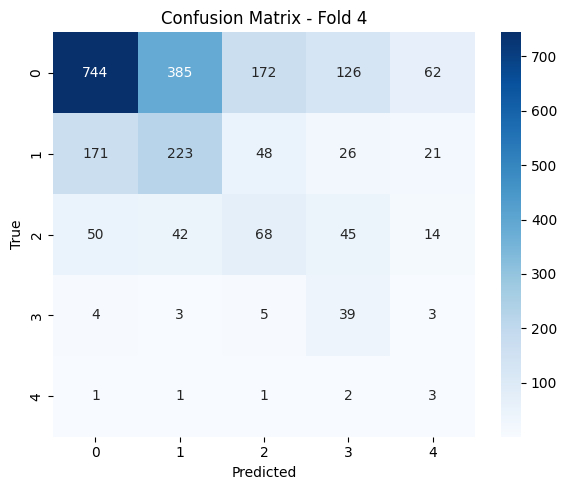

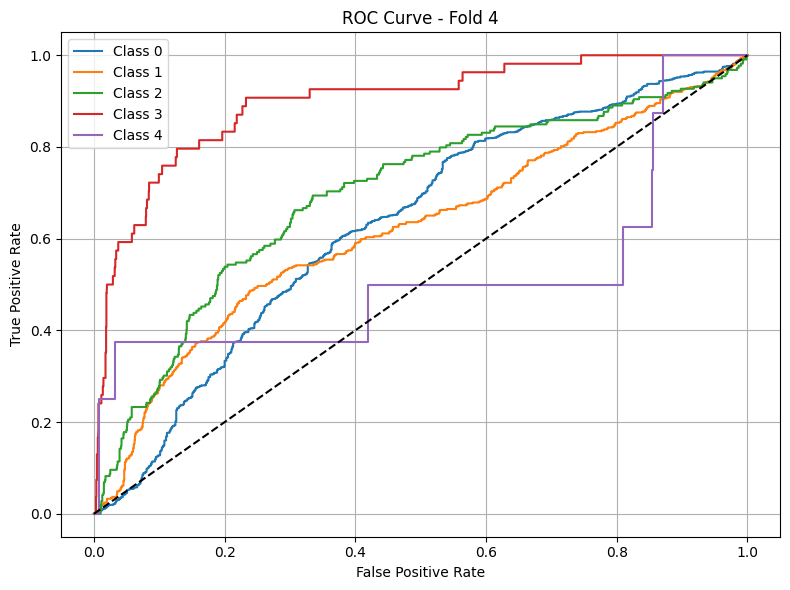


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.57      0.67      1490
           1       0.38      0.37      0.38       488
           2       0.20      0.52      0.29       219
           3       0.14      0.31      0.19        54
           4       0.08      0.62      0.14         8

    accuracy                           0.52      2259
   macro avg       0.32      0.48      0.33      2259
weighted avg       0.64      0.52      0.56      2259



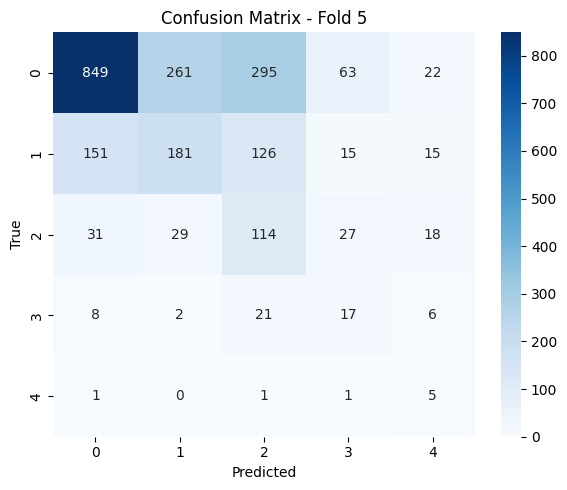

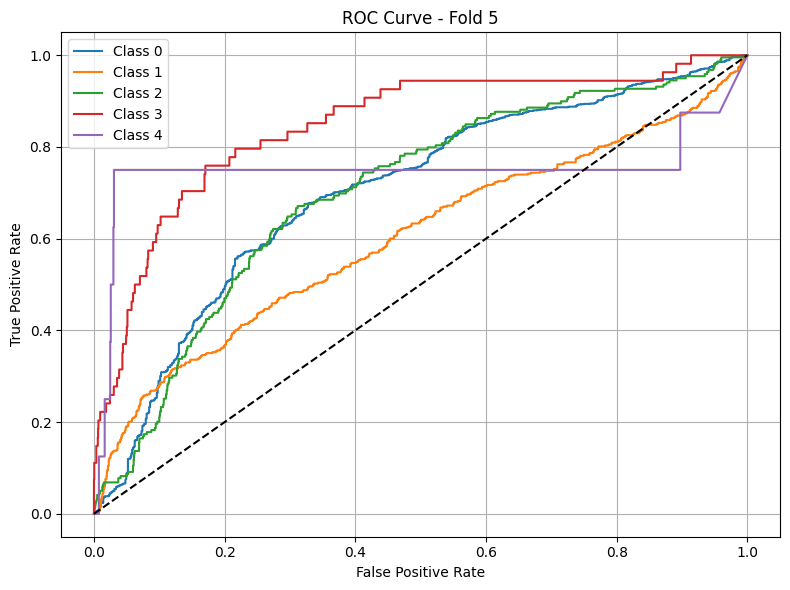


Average Accuracy: 0.4942
Average F1 Macro: 0.3349
Average AUC: 0.7021
{'phase1': [{'fold': 1, 'accuracy': 0.5079189686924493, 'f1_macro': 0.3372465616920607, 'auc': 0.7006312129640854}, {'fold': 2, 'accuracy': 0.45025792188651437, 'f1_macro': 0.3113128043586897, 'auc': 0.684101911590709}, {'fold': 3, 'accuracy': 0.48047162859248344, 'f1_macro': 0.32089997067207776, 'auc': 0.7425869861377731}, {'fold': 4, 'accuracy': 0.4285187914517318, 'f1_macro': 0.30223300364283723, 'auc': 0.7304120972753347}, {'fold': 5, 'accuracy': 0.44178334561532795, 'f1_macro': 0.3052622402414998, 'auc': 0.7274431692695017}], 'phase2': [{'fold': 1, 'accuracy': 0.5132743362831859, 'f1_macro': 0.3523930018892375, 'auc': 0.7206202635226627}, {'fold': 2, 'accuracy': 0.4831858407079646, 'f1_macro': 0.3384216979067374, 'auc': 0.6904652473744436}, {'fold': 3, 'accuracy': 0.4816290393979637, 'f1_macro': 0.3336840844335452, 'auc': 0.7074709839620337}, {'fold': 4, 'accuracy': 0.4767596281540505, 'f1_macro': 0.31632196264

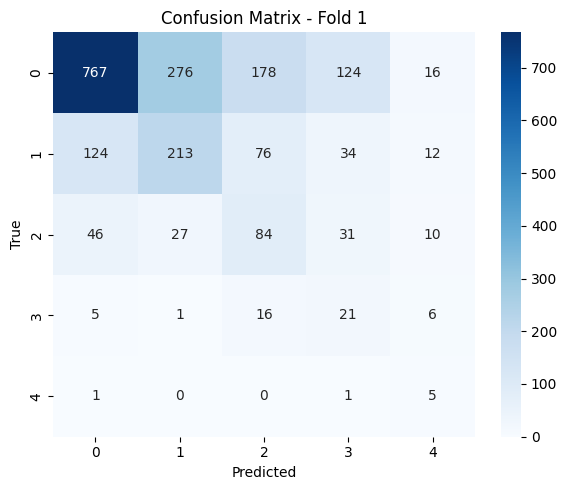

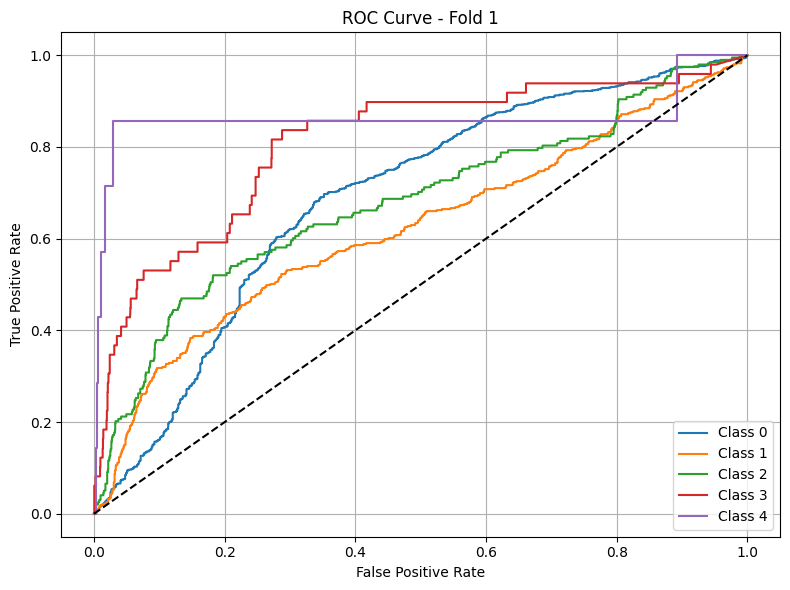


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.52      0.63      1360
           1       0.38      0.36      0.37       459
           2       0.24      0.59      0.34       198
           3       0.14      0.56      0.22        50
           4       0.04      0.43      0.08         7

    accuracy                           0.49      2074
   macro avg       0.32      0.49      0.33      2074
weighted avg       0.64      0.49      0.53      2074



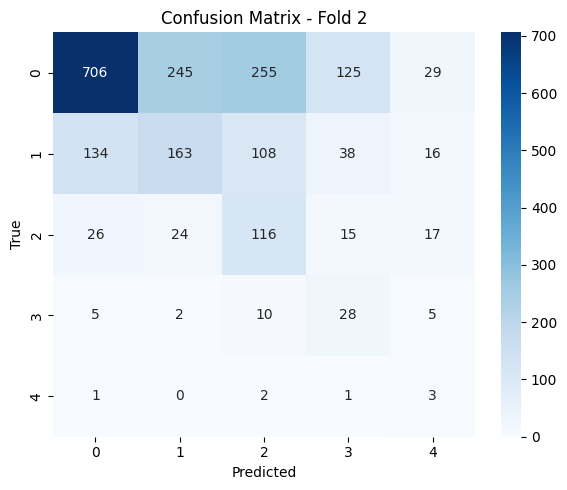

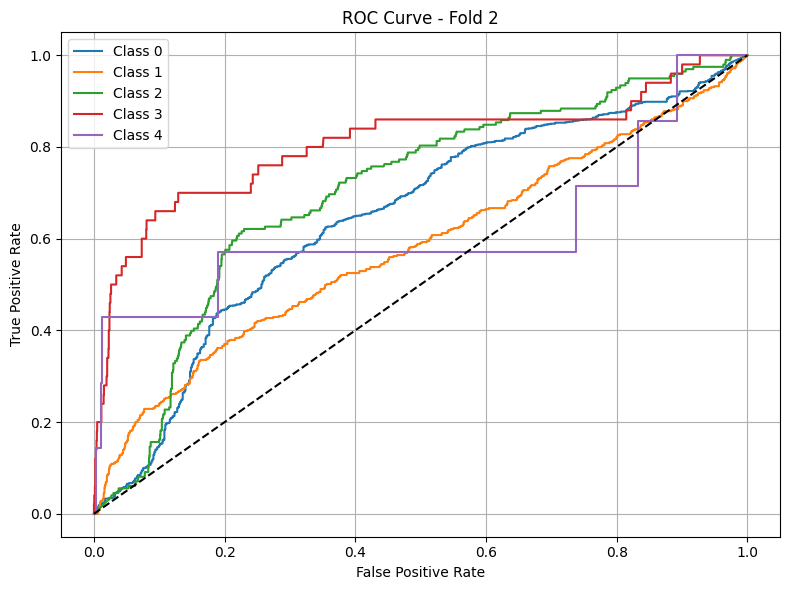


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.53      0.64      1360
           1       0.34      0.44      0.38       459
           2       0.22      0.37      0.28       198
           3       0.14      0.56      0.22        50
           4       0.06      0.43      0.10         7

    accuracy                           0.50      2074
   macro avg       0.31      0.47      0.33      2074
weighted avg       0.63      0.50      0.54      2074



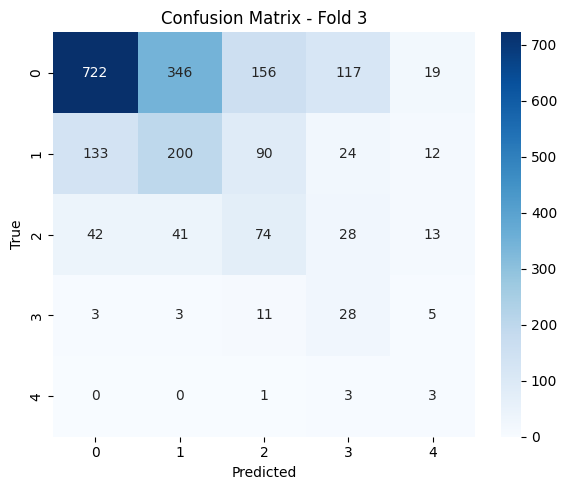

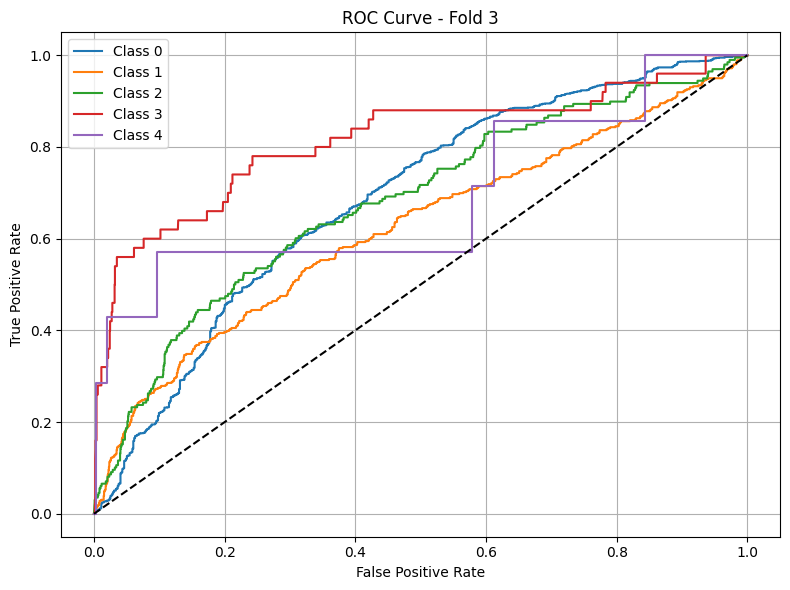


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.47      0.59      1360
           1       0.34      0.46      0.39       459
           2       0.21      0.33      0.25       198
           3       0.13      0.64      0.21        50
           4       0.06      0.71      0.10         7

    accuracy                           0.46      2074
   macro avg       0.31      0.52      0.31      2074
weighted avg       0.62      0.46      0.50      2074



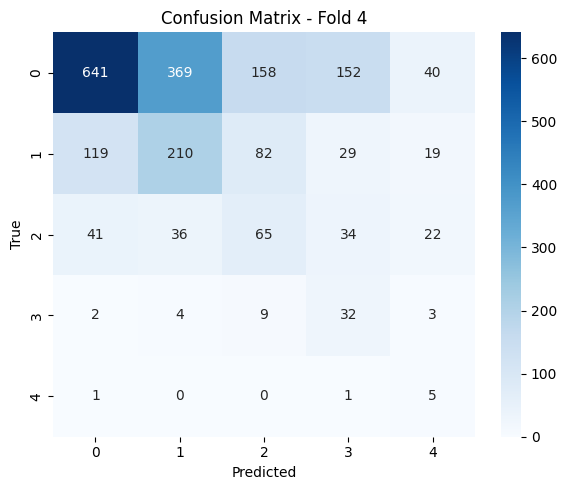

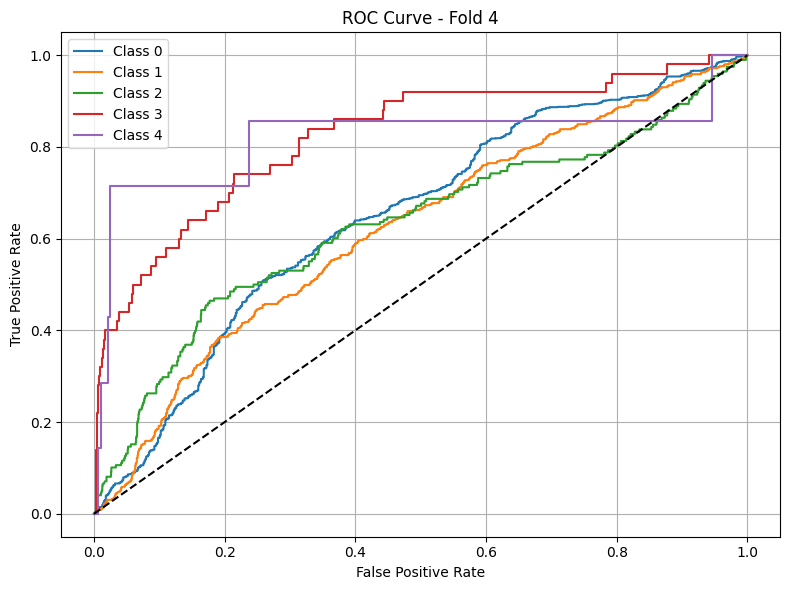


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.52      0.63      1360
           1       0.34      0.47      0.39       460
           2       0.21      0.42      0.28       197
           3       0.14      0.39      0.20        49
           4       0.06      0.29      0.09         7

    accuracy                           0.50      2073
   macro avg       0.31      0.42      0.32      2073
weighted avg       0.63      0.50      0.53      2073



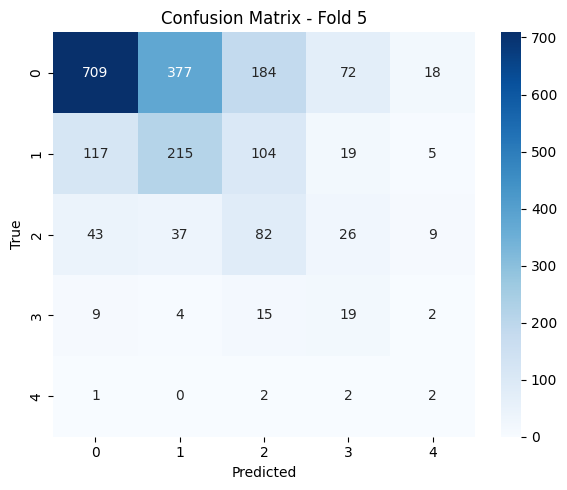

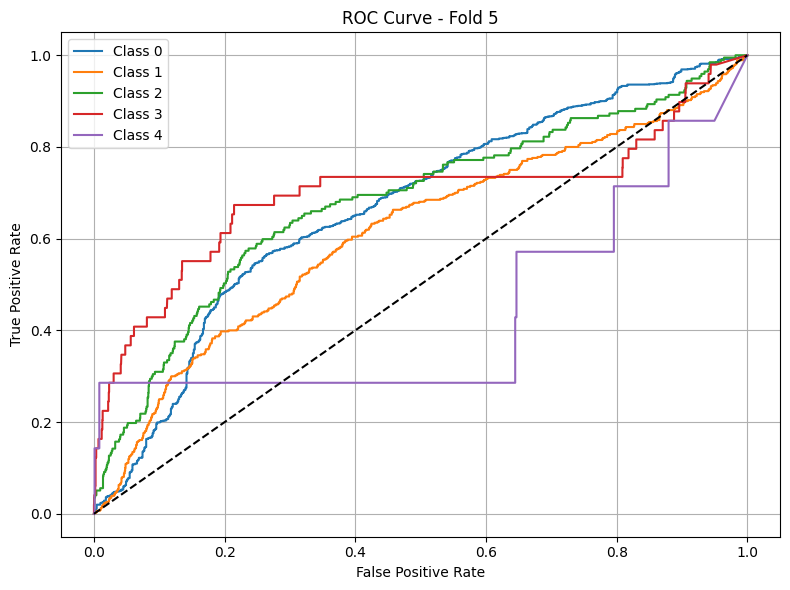


Average Accuracy: 0.4931
Average F1 Macro: 0.3264
Average AUC: 0.6862
{'phase1': [{'fold': 1, 'accuracy': 0.5079189686924493, 'f1_macro': 0.3372465616920607, 'auc': 0.7006312129640854}, {'fold': 2, 'accuracy': 0.45025792188651437, 'f1_macro': 0.3113128043586897, 'auc': 0.684101911590709}, {'fold': 3, 'accuracy': 0.48047162859248344, 'f1_macro': 0.32089997067207776, 'auc': 0.7425869861377731}, {'fold': 4, 'accuracy': 0.4285187914517318, 'f1_macro': 0.30223300364283723, 'auc': 0.7304120972753347}, {'fold': 5, 'accuracy': 0.44178334561532795, 'f1_macro': 0.3052622402414998, 'auc': 0.7274431692695017}], 'phase2': [{'fold': 1, 'accuracy': 0.5132743362831859, 'f1_macro': 0.3523930018892375, 'auc': 0.7206202635226627}, {'fold': 2, 'accuracy': 0.4831858407079646, 'f1_macro': 0.3384216979067374, 'auc': 0.6904652473744436}, {'fold': 3, 'accuracy': 0.4816290393979637, 'f1_macro': 0.3336840844335452, 'auc': 0.7074709839620337}, {'fold': 4, 'accuracy': 0.4767596281540505, 'f1_macro': 0.31632196264

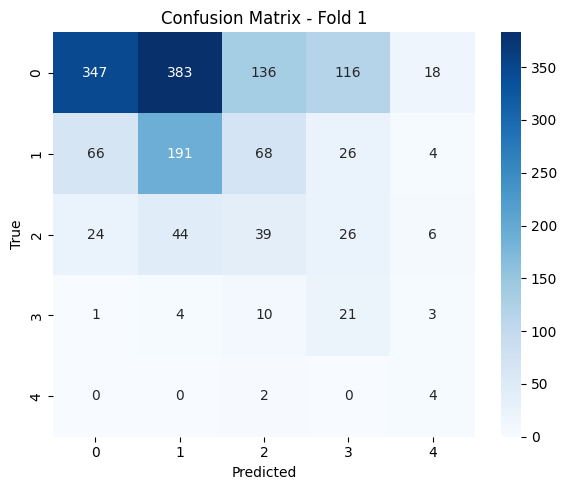

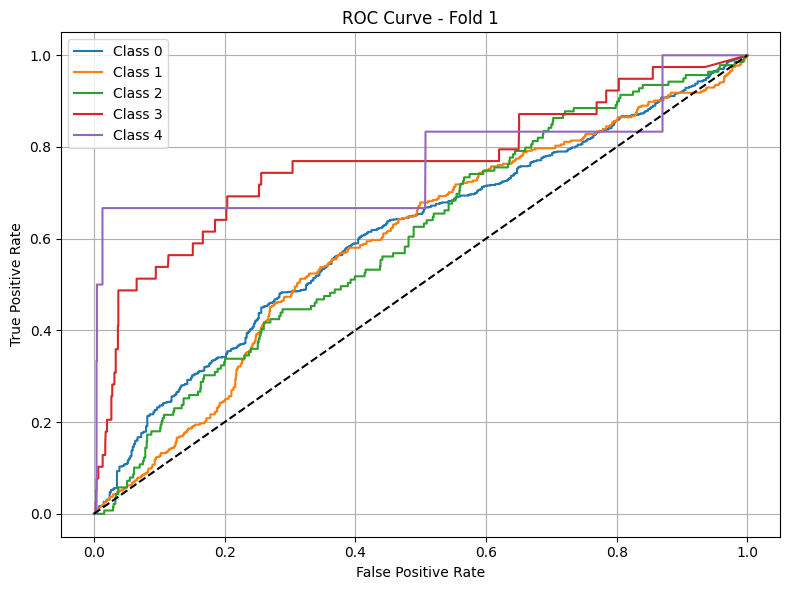


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.48      0.59      1000
           1       0.36      0.48      0.41       355
           2       0.26      0.32      0.28       139
           3       0.13      0.72      0.22        40
           4       0.06      0.60      0.12         5

    accuracy                           0.47      1539
   macro avg       0.32      0.52      0.32      1539
weighted avg       0.61      0.47      0.51      1539



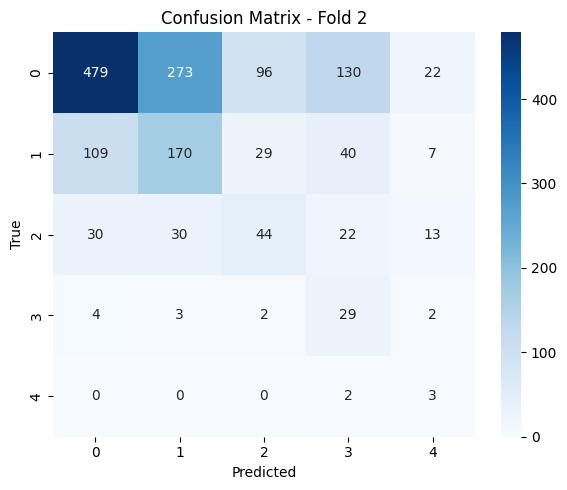

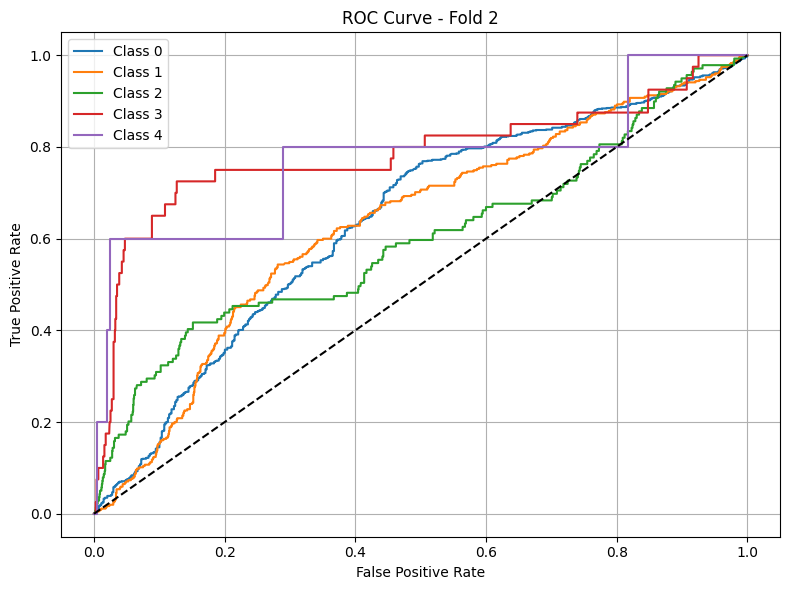


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.56      0.65       999
           1       0.35      0.42      0.38       355
           2       0.26      0.46      0.33       139
           3       0.17      0.47      0.25        40
           4       0.08      0.50      0.14         6

    accuracy                           0.52      1539
   macro avg       0.33      0.48      0.35      1539
weighted avg       0.62      0.52      0.55      1539



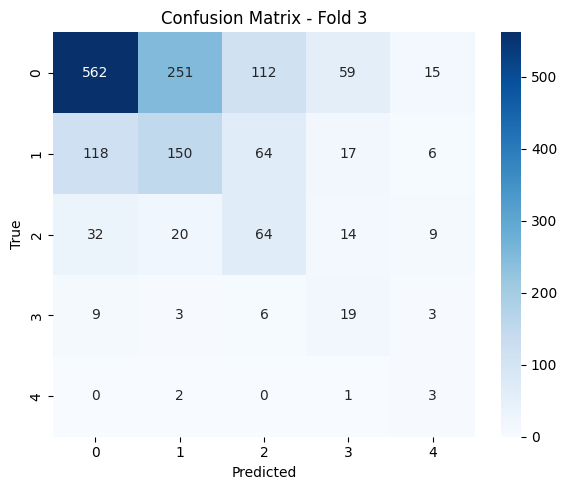

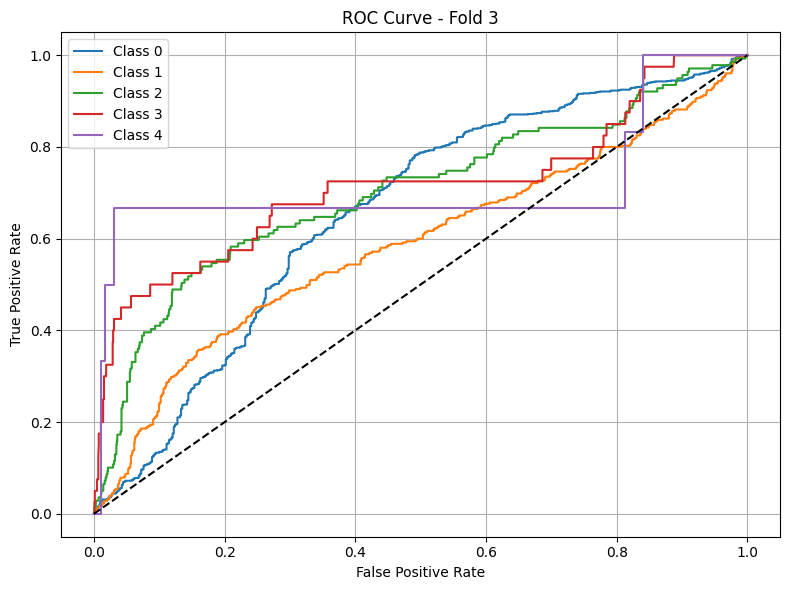


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.59      0.67       999
           1       0.36      0.40      0.38       356
           2       0.25      0.43      0.32       138
           3       0.19      0.51      0.28        39
           4       0.09      0.67      0.16         6

    accuracy                           0.53      1538
   macro avg       0.33      0.52      0.36      1538
weighted avg       0.62      0.53      0.56      1538



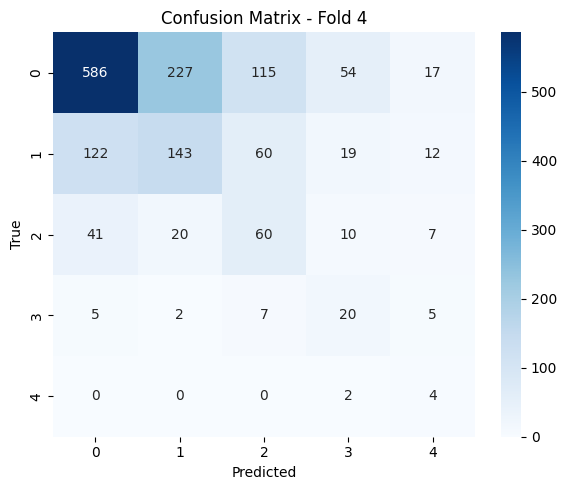

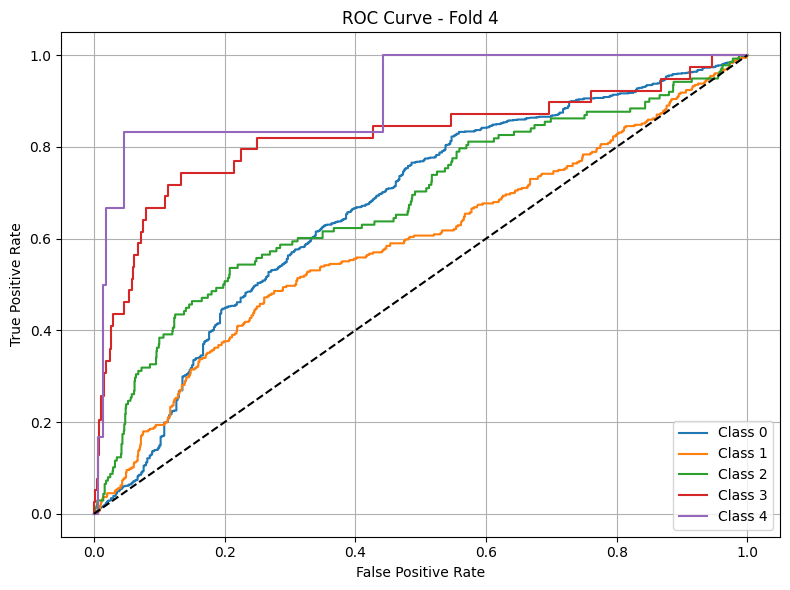


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.55      0.64       999
           1       0.37      0.37      0.37       356
           2       0.21      0.36      0.27       138
           3       0.13      0.69      0.22        39
           4       0.04      0.17      0.06         6

    accuracy                           0.49      1538
   macro avg       0.30      0.43      0.31      1538
weighted avg       0.60      0.49      0.53      1538



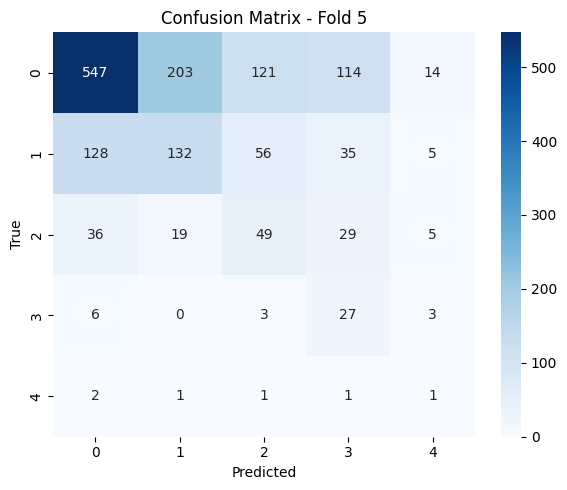

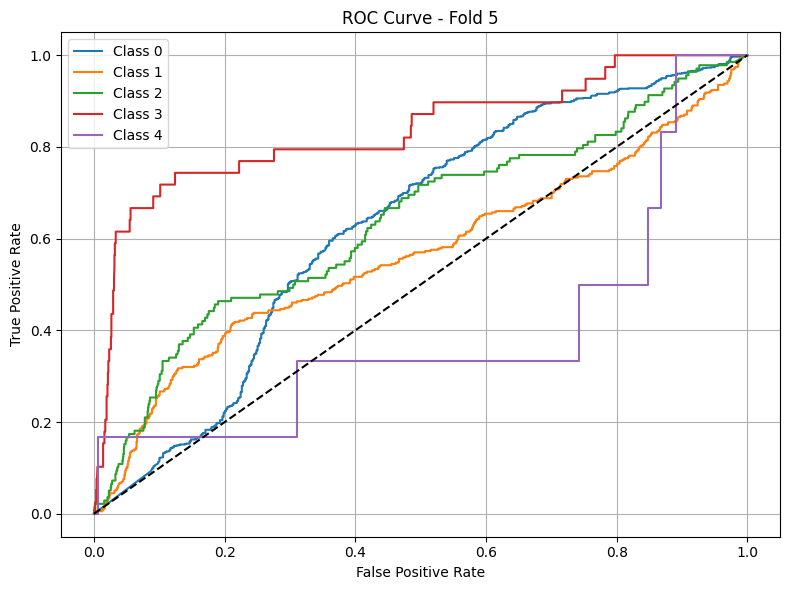


Average Accuracy: 0.4802
Average F1 Macro: 0.3277
Average AUC: 0.6741
{'phase1': [{'fold': 1, 'accuracy': 0.5079189686924493, 'f1_macro': 0.3372465616920607, 'auc': 0.7006312129640854}, {'fold': 2, 'accuracy': 0.45025792188651437, 'f1_macro': 0.3113128043586897, 'auc': 0.684101911590709}, {'fold': 3, 'accuracy': 0.48047162859248344, 'f1_macro': 0.32089997067207776, 'auc': 0.7425869861377731}, {'fold': 4, 'accuracy': 0.4285187914517318, 'f1_macro': 0.30223300364283723, 'auc': 0.7304120972753347}, {'fold': 5, 'accuracy': 0.44178334561532795, 'f1_macro': 0.3052622402414998, 'auc': 0.7274431692695017}], 'phase2': [{'fold': 1, 'accuracy': 0.5132743362831859, 'f1_macro': 0.3523930018892375, 'auc': 0.7206202635226627}, {'fold': 2, 'accuracy': 0.4831858407079646, 'f1_macro': 0.3384216979067374, 'auc': 0.6904652473744436}, {'fold': 3, 'accuracy': 0.4816290393979637, 'f1_macro': 0.3336840844335452, 'auc': 0.7074709839620337}, {'fold': 4, 'accuracy': 0.4767596281540505, 'f1_macro': 0.31632196264

In [9]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = True
    
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")

    results[f"phase{i}"] = metrics
    print(results)


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       568
           1       0.10      0.24      0.14        63
           2       0.22      0.40      0.28        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.63       698
   macro avg       0.24      0.27      0.24       698
weighted avg       0.75      0.63      0.68       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


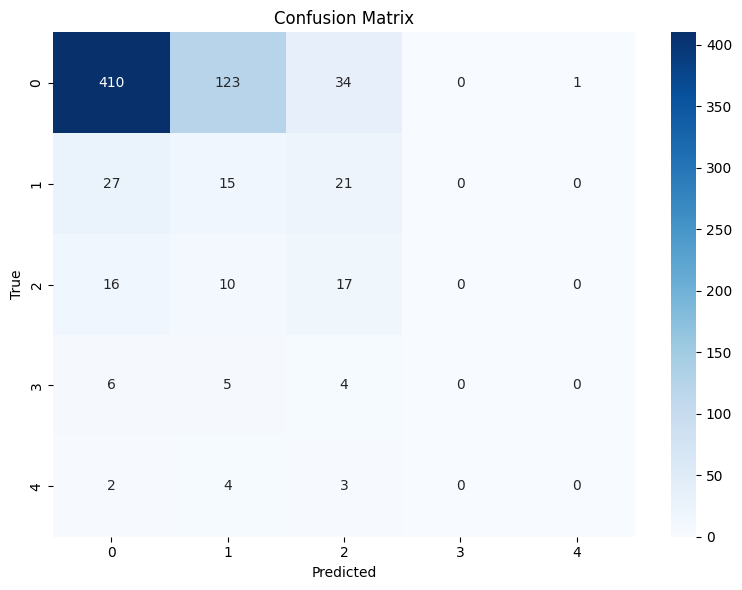


Test AUC (macro-average, OVR): 0.5757


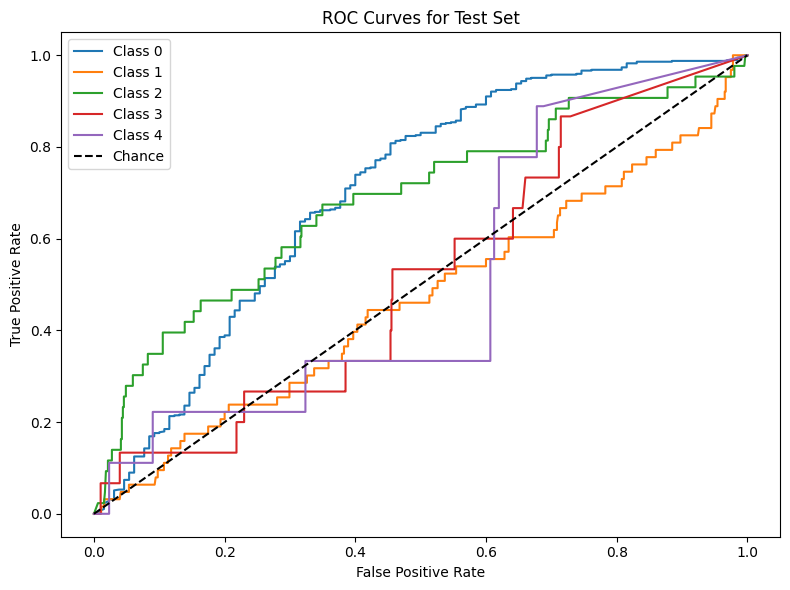


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       544
           1       0.08      0.22      0.12        59
           2       0.13      0.38      0.20        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.55       668
   macro avg       0.22      0.25      0.21       668
weighted avg       0.73      0.55      0.62       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


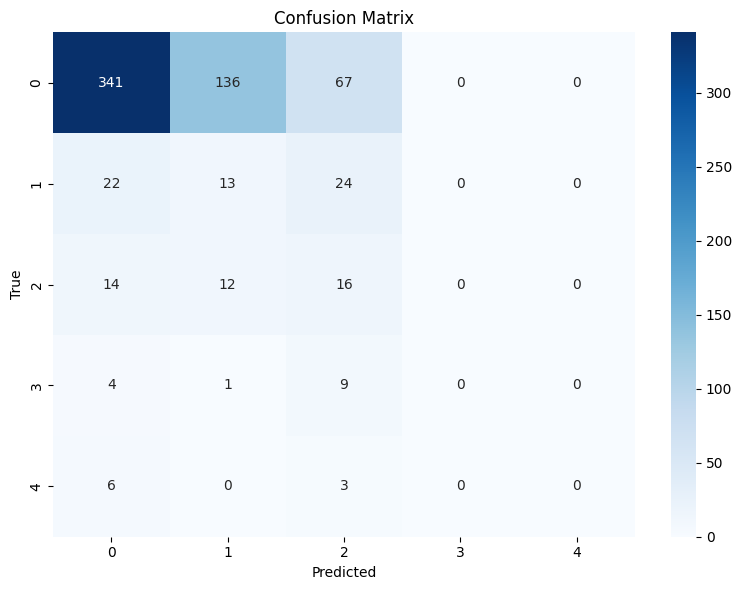


Test AUC (macro-average, OVR): 0.5027


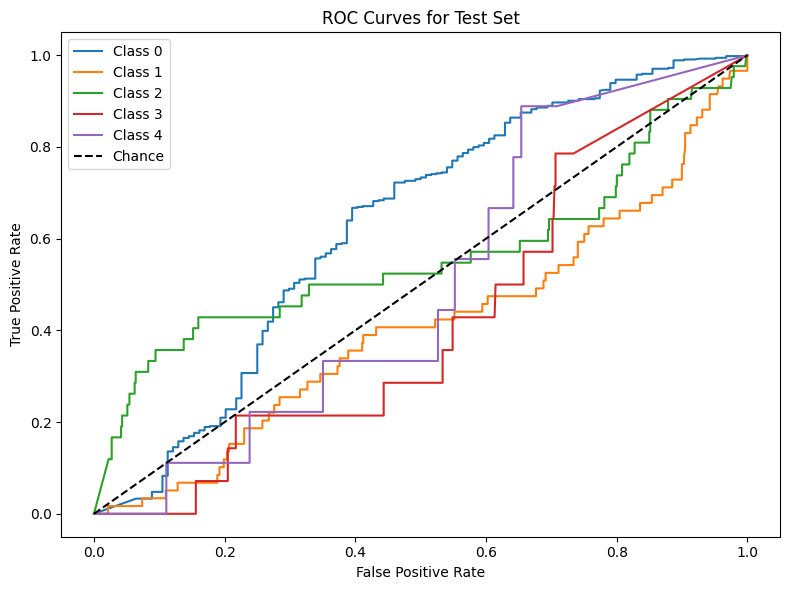


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.58      0.70       455
           1       0.06      0.15      0.09        52
           2       0.12      0.41      0.18        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.52       554
   macro avg       0.21      0.23      0.19       554
weighted avg       0.73      0.52      0.59       554



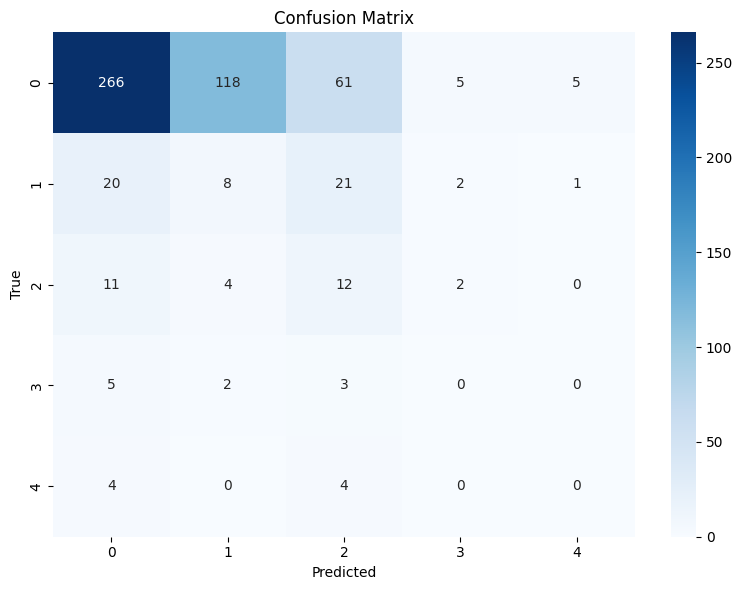


Test AUC (macro-average, OVR): 0.4835


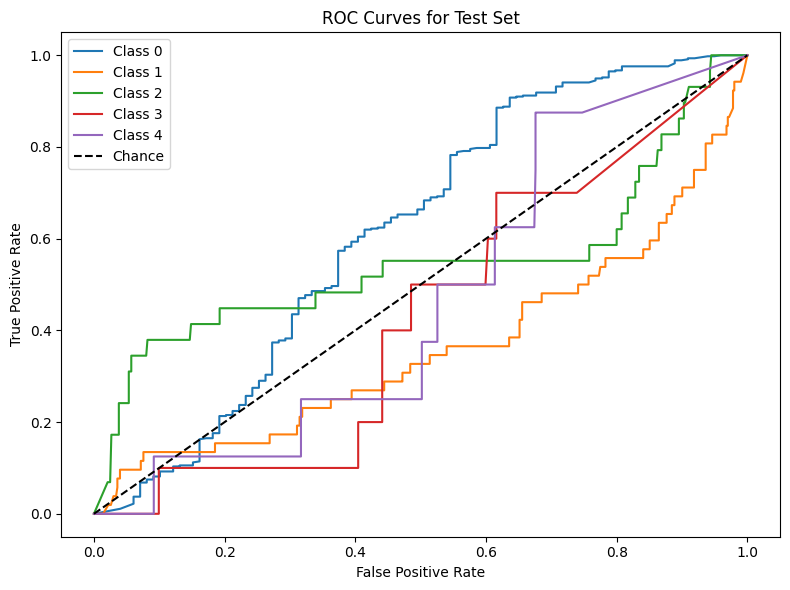


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.74      0.81       395
           1       0.10      0.12      0.11        40
           2       0.10      0.29      0.15        24
           3       0.00      0.00      0.00        10
           4       0.15      0.38      0.21         8

    accuracy                           0.65       477
   macro avg       0.25      0.31      0.26       477
weighted avg       0.74      0.65      0.69       477



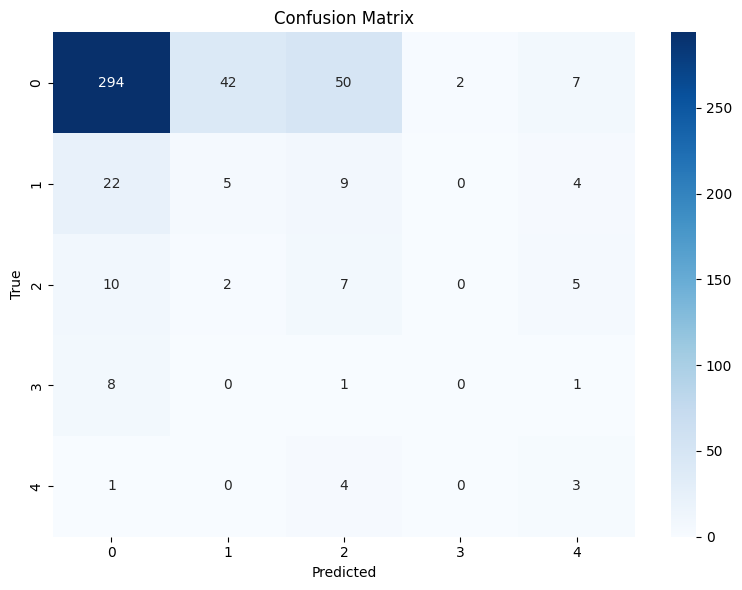


Test AUC (macro-average, OVR): 0.5140


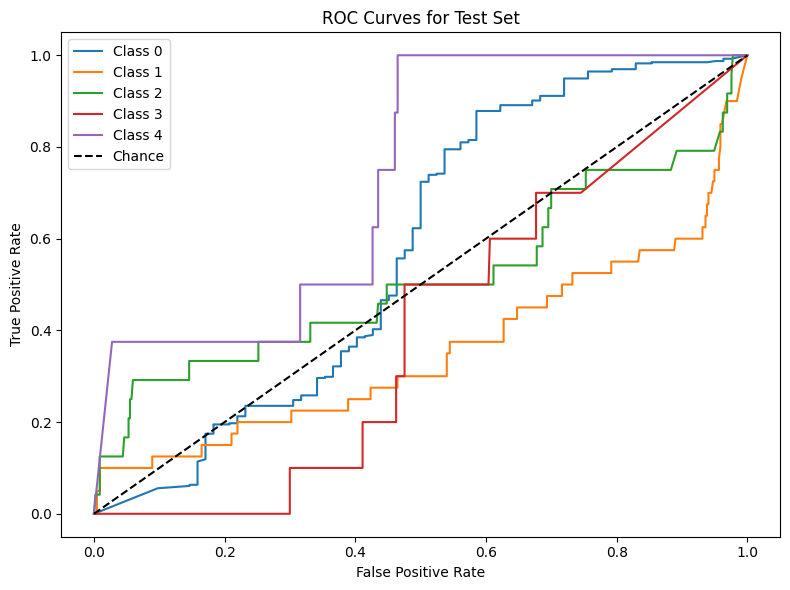

In [10]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )